# Import Libraries

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, SimpleRNN, Dropout
from tensorflow.keras.models import Model
from keras.layers import Input, InputLayer
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.tree import DecisionTreeRegressor

import numpy as np
import math
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import csv
from keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
import seaborn as sns
from tensorflow.keras.regularizers import l2
from sklearn.decomposition import PCA


#plt.style.use('fivethirtyeight')
#plt.rcParams['axes.facecolor'] = 'white'  # Set the axes background color to white
#plt.rcParams['figure.facecolor'] = 'white'  # Set the figure background color to white         # Axes background color
#plt.rcParams['axes.labelcolor'] = 'black'  # Set x and y label colors to black
#plt.rcParams['xtick.color'] = 'black'  # Set x-tick color to black
#plt.rcParams['ytick.color'] = 'black'  # Set y-tick color to black

# Analysis

In [ ]:
data = pd.read_csv("Greenhouse_climate.csv")
data["AssimLight"] = np.where(data["AssimLight"] <50 , "OFF", "ON")
data["AssimLight"].describe()
#sns.countplot(data=data['AssimLight'])

,AssimLight
count,33133
unique,2
top,ON
freq,18835


AssimLight Analysis

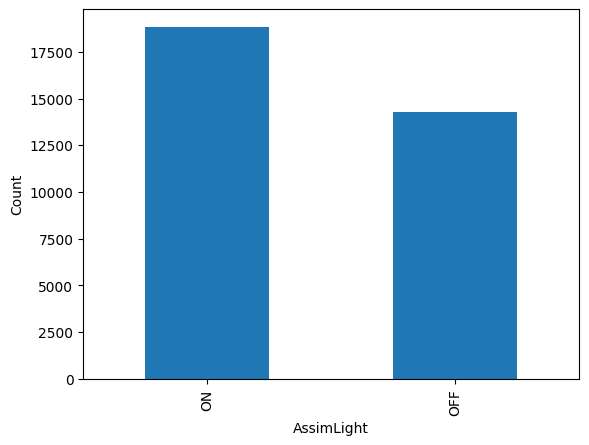

In [ ]:
data['AssimLight'].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('AssimLight')
plt.savefig("AssimLight.png", dpi = 200)
plt.show()

Remaining Parameters Analysis

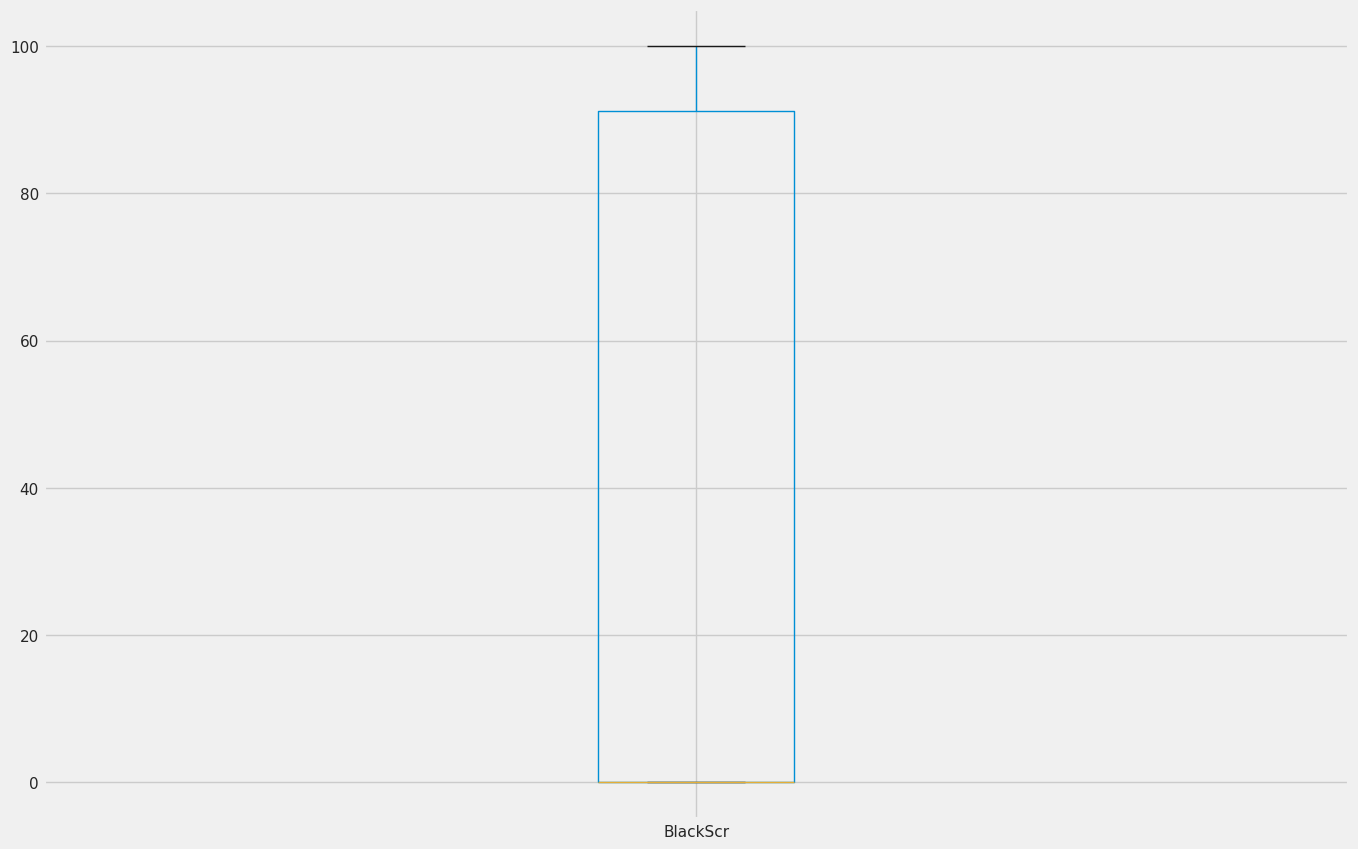

In [ ]:
#Change "BlackScr" to analysis a different parameter
dt =pd.read_csv("Greenhouse_climate.csv")
dt.boxplot(column =['BlackScr'])
plt.savefig('Curt.png', dpi = 200)
plt.show()

<ipython-input-97-52b417f11dfe>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=dt['BlackScr'], hist=False)


<Axes: xlabel='BlackScr', ylabel='Density'>

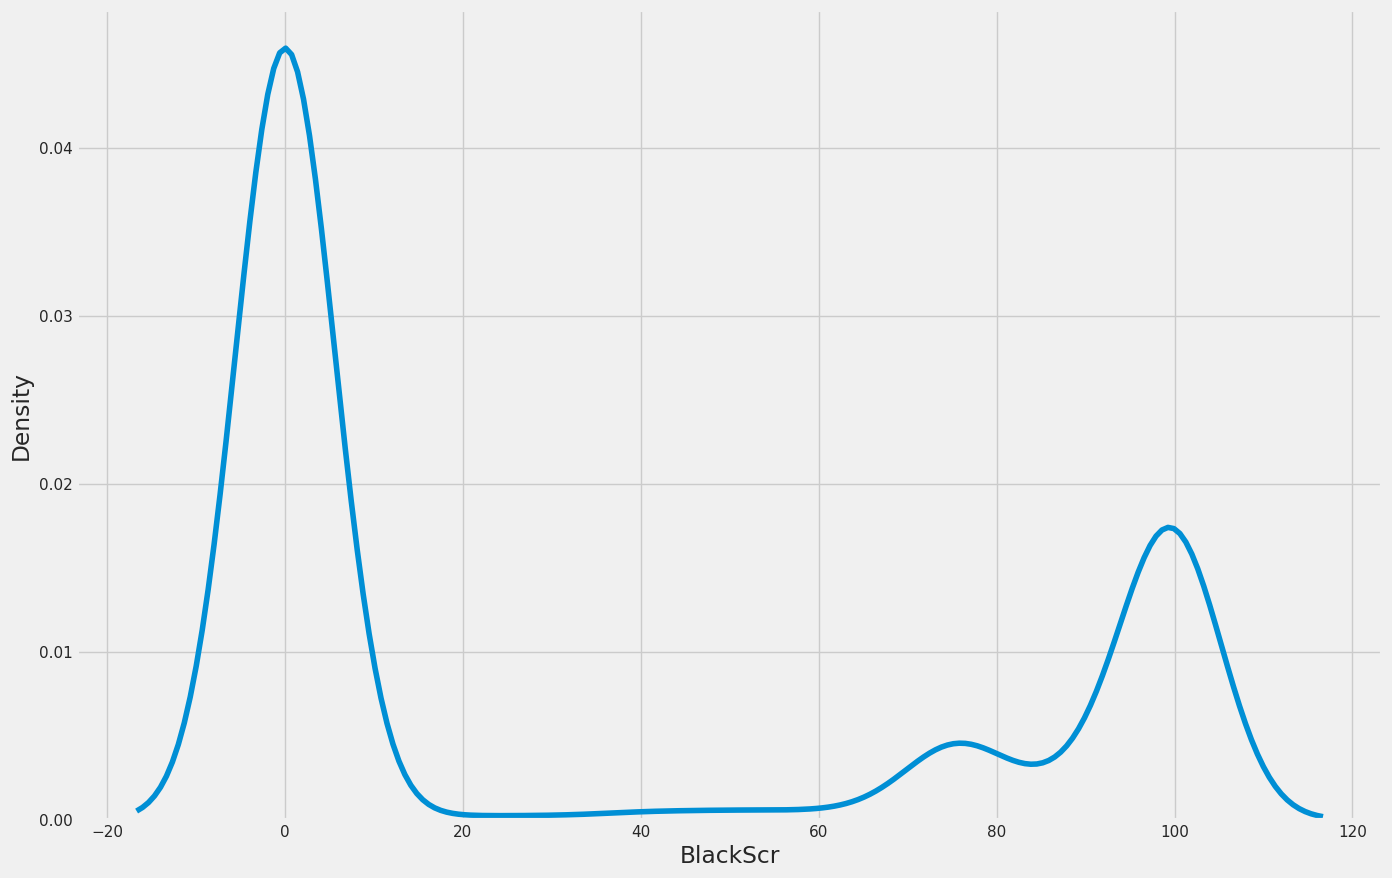

In [ ]:
sns.distplot(a=dt['BlackScr'], hist=False)

# Data Preprocessing

In [ ]:
data = pd.read_csv("Greenhouse_climate.csv")
data = data.drop(['GHtime','EnScr'], axis = 1)
data = data.dropna()
data.drop(data.tail(13).index,inplace = True)

scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()
scaler_robust = RobustScaler()
#data = scaler.fit_transform(data)
#Y = data[:, -1] # for last column
#X = data[:, :-1] # all columns except the last one
data
data[['CO2air']] = scaler_standard.fit_transform(data[['CO2air']])

# Applying MinMaxScaler to CO2 dosage (scaling between 0 and 1)
data['PipeGrow'] = scaler_minmax.fit_transform(data[['PipeGrow']])
data['BlackScr'] = scaler_minmax.fit_transform(data[['BlackScr']])
data['AssimLight'] = scaler_minmax.fit_transform(data[['AssimLight']])

# Applying RobustScaler to soil_ph and soil_ec (handling outliers)
data[['VentLee', 'RHair', 'Tair', 'Ventwind', 'PipeLow','HumDef']] = scaler_robust.fit_transform(data[['VentLee', 'RHair', 'Tair', 'Ventwind', 'PipeLow','HumDef']])

Reshape data

In [ ]:
df = data
timestep = 288
new_data = []
for i in range(115):
    new_data.append(df[i:i+timestep])

In [ ]:
X = np.array(new_data)

# Print the shapes of the reshaped arrays
print("X shape:", X.shape)
X = X.reshape(115,288,10,1)

X shape: (115, 288, 10)


# PCA

In [ ]:
pcas = []
ncomponents=9
for matrix in new_data:
  pca = PCA(ncomponents)  # Retain 95% of the variance

  # Fit PCA on the scaled data
  pca_components = pca.fit_transform(matrix)

  pcas.append(pca_components.flatten()[:ncomponents])

In [ ]:
print(pcas)

[array([-3.65769436e+00,  8.43258187e-01, -9.83181432e-01, -1.90799920e-01,
        5.25140536e-02, -5.12228918e-02,  8.98385987e-16,  3.43291873e-17,
       -1.31984569e-17]), array([-3.65801063e+00,  8.47530934e-01, -9.77678441e-01, -1.88941357e-01,
        5.81488898e-02,  1.10551532e-02,  8.94360181e-16,  8.29767311e-16,
        2.53046072e-18]), array([-3.70621266e+00,  9.64778657e-01, -9.68262469e-01, -1.65316120e-01,
        6.51299490e-02,  1.41177601e-02,  8.94717094e-16, -7.47049844e-16,
        2.33156392e-17]), array([-3.83145381e+00,  1.38273944e+00, -7.44797590e-01, -1.98781876e-01,
        7.06180669e-02, -9.69231209e-03,  8.88754454e-16, -3.46863737e-16,
        3.51205673e-17]), array([-3.85178526e+00,  1.41329680e+00, -7.87551226e-01, -1.23029607e-01,
        5.07155979e-02,  1.32569816e-02,  8.83763506e-16, -1.40049346e-16,
       -3.61203379e-18]), array([-3.98638051e+00,  1.88810845e+00, -5.27185776e-01, -1.24749197e-01,
        4.29917636e-02,  3.03555373e-02,  8.

Analyze results

In [ ]:
df_pca = pd.DataFrame(pcas)
df_pca.describe()

,0,1,2,3,4,5,6,7,8
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,1.150000e+02,1.150000e+02,1.150000e+02
mean,-3.934109,2.528292,0.669819,-0.062166,0.021122,-0.041999,8.869683e-16,-2.327805e-17,3.072041e-17
std,0.778883,1.757735,1.162041,0.118013,0.038042,0.058278,2.472016e-17,8.124594e-16,7.683839e-17
min,-4.960181,-2.488692,-0.983181,-0.299962,-0.088320,-0.194764,7.216338e-16,-2.261056e-15,-6.927119e-17
25%,-4.245108,1.955680,-0.379449,-0.149062,0.003388,-0.081750,8.793292e-16,-5.431962e-16,-5.547573e-18
50%,-4.088242,3.012855,0.203803,-0.064751,0.023886,-0.040944,8.885777e-16,-1.010129e-16,1.249542e-17
75%,-3.775876,3.453702,1.799525,-0.000983,0.049095,-0.004624,8.971333e-16,5.396577e-16,3.662417e-17
max,-0.745115,4.435875,2.790662,0.333305,0.093363,0.147337,9.632286e-16,1.903852e-15,4.797095e-16


save features

In [ ]:
data2 = pd.read_csv("Irrigation.csv")


scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()
scaler_robust = RobustScaler()


data2[['EC_Drain']] = scaler_standard.fit_transform(data2[['EC_Drain']])




# Applying RobustScaler to soil_ph and soil_ec (handling outliers)
data2[['pH_Drain']] = scaler_robust.fit_transform(data2[['pH_Drain']])

first = []
for i in range(0,ncomponents):
  first.append("Parameter"+str(i))
first.append("pH_Drain")
first.append("EC_Drain")
first.append("water")

with open('new_featuresPCA.csv','w') as out:
    csv_out=csv.writer(out)
    i = 0
    csv_out.writerow(first)
    for index, row in df_pca.iterrows():
        row = np.append(row, np.array([data2["pH_Drain"][i], data2["EC_Drain"][i], data2["water"][i]]))
        #print(len(row))
        csv_out.writerow(row)
        i = i+1

    # You can also do csv_out.writerows(data) instead of the for loop

# TSNE

In [ ]:
tsnes = []
ncomponents=2
for matrix in new_data:
  tsne = TSNE(ncomponents)  # Retain 95% of the variance

  # Fit tsne on the scaled data
  tsne_components = tsne.fit_transform(matrix)

  tsnes.append(tsne_components.flatten()[:ncomponents])

In [ ]:
print(tsnes)

[array([-18.011633 ,   7.1029544], dtype=float32), array([-18.507618,   5.091819], dtype=float32), array([-9.255486, 14.813282], dtype=float32), array([-19.182669,   2.559872], dtype=float32), array([-17.541588 ,   6.4716086], dtype=float32), array([-17.567904 ,   3.9544663], dtype=float32), array([-10.024148,  10.673794], dtype=float32), array([-13.658685,   9.263265], dtype=float32), array([-17.96066  ,   3.8692858], dtype=float32), array([-15.100786,   8.716266], dtype=float32), array([-4.752232, 12.99041 ], dtype=float32), array([-15.358161,   8.840775], dtype=float32), array([-6.954837, 11.826998], dtype=float32), array([ -3.100257 , -15.3182335], dtype=float32), array([  1.9776961, -17.087116 ], dtype=float32), array([-15.975355,   6.603505], dtype=float32), array([-11.059062,  11.261112], dtype=float32), array([-13.193465,   8.538637], dtype=float32), array([-13.248637 ,   7.0349493], dtype=float32), array([-16.061075,   4.229562], dtype=float32), array([-5.8003025, 13.870895 ],

Analyze results

In [ ]:
df_pca = pd.DataFrame(tsnes)
df_pca.describe()

,0,1
count,115.000000,115.000000
mean,-8.160290,4.472170
std,6.006118,6.946569
min,-19.182669,-17.087116
25%,-12.273806,-0.719376
50%,-8.694805,6.954937
75%,-5.851523,9.570636
max,9.540041,14.813282


save features

In [ ]:
data2 = pd.read_csv("Irrigation.csv")


scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()
scaler_robust = RobustScaler()


data2[['EC_Drain']] = scaler_standard.fit_transform(data2[['EC_Drain']])




# Applying RobustScaler to soil_ph and soil_ec (handling outliers)
data2[['pH_Drain']] = scaler_robust.fit_transform(data2[['pH_Drain']])

first = []
for i in range(0,ncomponents):
  first.append("Parameter"+str(i))
first.append("pH_Drain")
first.append("EC_Drain")
first.append("water")

with open('new_featuresTSNE.csv','w') as out:
    csv_out=csv.writer(out)
    i = 0
    csv_out.writerow(first)
    for index, row in df_pca.iterrows():
        row = np.append(row, np.array([data2["pH_Drain"][i], data2["EC_Drain"][i], data2["water"][i]]))
        #print(len(row))
        csv_out.writerow(row)
        i = i+1

    # You can also do csv_out.writerows(data) instead of the for loop

# ISOMAP

In [ ]:
isomaps = []
ncomponents=9
for matrix in new_data:
  isomap = Isomap(n_components=ncomponents)  # Retain 95% of the variance

  # Fit isomap on the scaled data
  isomap_components = isomap.fit_transform(matrix)

  isomaps.append(isomap_components.flatten()[:ncomponents])

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 6 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages

In [ ]:
print(isomaps)

[array([-2.57892531e+00, -2.01289764e+00,  1.74200853e+00, -8.06218781e-01,
       -7.28870223e-01, -1.94772082e+00, -9.18146054e-02,  4.65931745e-01,
        1.06046033e-04]), array([-2.52750536e+00, -1.99794413e+00,  1.71809745e+00, -8.16934302e-01,
       -6.11982705e-01, -2.06355823e+00, -8.71253456e-02,  4.91377355e-01,
       -1.50319600e-04]), array([-2.60627681e+00, -2.08105815e+00,  1.70314920e+00, -7.70780119e-01,
       -4.68850376e-01, -2.14779919e+00, -5.50057982e-02,  6.14795162e-01,
        4.89818655e-04]), array([-2.87778789e+00, -2.34096623e+00,  1.63467102e+00, -5.92650808e-01,
       -7.44936134e-01, -1.66662139e+00, -3.96318987e-01, -9.94857106e-01,
        2.25716715e-03]), array([-2.89689413, -2.38359144,  1.58445169, -0.57223872, -0.17494842,
       -1.90325835,  0.22011907,  0.87385839,  0.0045763 ]), array([-3.55155181, -2.80637122,  1.52168992, -0.20573346,  0.27451252,
       -1.19605001,  0.51829057,  0.62982449,  0.00539674]), array([-3.53894998, -2.822773

Analyze results

In [ ]:
df_pca = pd.DataFrame(isomaps)
df_pca.describe()

,0,1,2,3,4,5,6,7,8
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,-7.484814,-0.344416,-0.259255,-0.139545,0.150587,0.147343,0.152637,-0.006709,-0.066013
std,2.795730,3.835179,2.153319,0.496423,1.092007,0.818444,0.697612,0.341520,0.253394
min,-10.904166,-5.209257,-3.800028,-1.718978,-1.840837,-2.147799,-1.371622,-1.034786,-0.916927
25%,-9.278737,-3.396202,-0.991041,-0.331023,-0.736903,-0.078753,-0.035570,-0.077410,-0.135560
50%,-8.659865,-2.081058,-0.582575,-0.025731,0.024339,0.011010,0.000510,-0.018338,-0.009380
75%,-6.520278,2.109076,0.015706,0.034804,1.094966,0.270389,0.448274,0.000081,0.006856
max,0.035609,6.603241,5.582965,3.505951,3.196485,2.409265,2.363254,2.070678,1.072419


save features

In [ ]:
data2 = pd.read_csv("Irrigation.csv")


scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()
scaler_robust = RobustScaler()


data2[['EC_Drain']] = scaler_standard.fit_transform(data2[['EC_Drain']])




# Applying RobustScaler to soil_ph and soil_ec (handling outliers)
data2[['pH_Drain']] = scaler_robust.fit_transform(data2[['pH_Drain']])

first = []
for i in range(0,ncomponents):
  first.append("Parameter"+str(i))
first.append("pH_Drain")
first.append("EC_Drain")
first.append("water")

with open('new_featuresISOMAP.csv','w') as out:
    csv_out=csv.writer(out)
    i = 0
    csv_out.writerow(first)
    for index, row in df_pca.iterrows():
        row = np.append(row, np.array([data2["pH_Drain"][i], data2["EC_Drain"][i], data2["water"][i]]))
        #print(len(row))
        csv_out.writerow(row)
        i = i+1

    # You can also do csv_out.writerows(data) instead of the for loop

# Design CNN Model

In [ ]:

model = Sequential()

# Add CNN layers for feature extraction
model.add(Conv2D(16, (2,2), activation='relu', input_shape=(288, 10, 1), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (2,2), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (2,2), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mse'])

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 288, 10, 16)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 144, 5, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 144, 5, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 72, 2, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 72, 2, 64)           │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 36, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2304)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,416 (40.69 KB)

 Trainable params: 10,416 (40.69 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
flatten_output = model.predict(X)
print(flatten_output)
featureNB = len(flatten_output[0])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.8858049  0.21635433 0.3615741  ... 0.46548414 0.41978094 1.0877489 ]
 [0.88580924 0.20804316 0.36973274 ... 0.46584895 0.41848585 1.0922267 ]
 [0.88307244 0.20244735 0.3735668  ... 0.4703873  0.4170892  1.0899726 ]
 ...
 [0.93908364 0.4057245  0.00585993 ... 0.4832342  0.42218933 1.0944932 ]
 [0.94075274 0.3809081  0.008616   ... 0.49048525 0.42361194 1.0970558 ]
 [0.9856156  0.36727312 0.01964608 ... 0.50281316 0.42784014 1.0987768 ]]


# Save features

In [ ]:
data2 = pd.read_csv("Irrigation.csv")


scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()
scaler_robust = RobustScaler()

# Applying scaler_standard soil_ec (handling outliers)
data2[['EC_Drain']] = scaler_standard.fit_transform(data2[['EC_Drain']])

# Applying RobustScaler to soil_ph
data2[['pH_Drain']] = scaler_robust.fit_transform(data2[['pH_Drain']])

In [ ]:
first = []
for i in range(0,2304):
  first.append("Parameter"+str(i))
first.append("pH_Drain")
first.append("EC_Drain")
first.append("water")

with open('new_features.csv','w') as out:
    csv_out=csv.writer(out)
    i = 0
    csv_out.writerow(first)
    for row in flatten_output:
        row = np.append(row, np.array([data2["pH_Drain"][i], data2["EC_Drain"][i], data2["water"][i]]))
        #print(len(row))
        featureNB = len(row)
        csv_out.writerow(row)
        i = i+1

    # You can also do csv_out.writerows(data) instead of the for loop

# Data Preparation

In [ ]:
def remove_const(df):
  #for i in range(0,2304):
  for i in range(0,ncomponents):
    #data = clean_dataset(data)
    if all(df['Parameter'+str(i)] == 0):
        # Drop the column if the condition is met
        df.drop('Parameter'+str(i), axis=1, inplace=True)
  return df


In [ ]:
data = pd.read_csv("new_features.csv")
#data = data.dropna(axis=0, how='any', subset=None, inplace=False)
data = data.dropna()
data.replace([np.inf, -np.inf], 1, inplace=True)
data = remove_const(data)
data = data.reset_index()
data.describe()


,index,Parameter0,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,pH_Drain,EC_Drain,water
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,56.929825,-7.481745,-0.397866,-0.253404,-0.140173,0.151759,0.148635,0.153399,-0.007383,-0.066660,-0.521584,0.002376,3.510987
std,33.480339,2.807879,3.808847,2.161908,0.498569,1.096755,0.821940,0.700644,0.342951,0.254418,2.059353,1.012989,1.312840
min,0.000000,-10.904166,-5.209257,-3.800028,-1.718978,-1.840837,-2.147799,-1.371622,-1.034786,-0.916927,-7.222891,-1.620433,0.406125
25%,28.250000,-9.313262,-3.397898,-1.001015,-0.342800,-0.740920,-0.079692,-0.040045,-0.077764,-0.136233,-0.387340,-0.716804,2.927400
50%,56.500000,-8.668018,-2.106911,-0.576481,-0.024711,0.025275,0.011106,0.000471,-0.018924,-0.011061,0.025060,-0.198346,3.444000
75%,85.750000,-6.433961,2.061780,0.052432,0.035000,1.095379,0.303725,0.455867,0.000073,0.006283,0.624717,0.581830,4.132800
max,114.000000,0.035609,6.603241,5.582965,3.505951,3.196485,2.409265,2.363254,2.070678,1.072419,0.823526,2.363338,7.921200


In [ ]:
Y = data.iloc[ :, -1:]
Y = Y.values.reshape(-1, 1) # Convert to a NumPy array and reshape to a column vector
data.pop(data.columns[-1])
data = data.reset_index(drop= True)
#data = scaler.fit_transform(data)
#Y = data[:, -1] # for last column
#X = data[:, :-1] # all columns except the last one

X = data.to_numpy()
data.describe()

,index,Parameter0,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,pH_Drain,EC_Drain
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,56.929825,-7.481745,-0.397866,-0.253404,-0.140173,0.151759,0.148635,0.153399,-0.007383,-0.066660,-0.521584,0.002376
std,33.480339,2.807879,3.808847,2.161908,0.498569,1.096755,0.821940,0.700644,0.342951,0.254418,2.059353,1.012989
min,0.000000,-10.904166,-5.209257,-3.800028,-1.718978,-1.840837,-2.147799,-1.371622,-1.034786,-0.916927,-7.222891,-1.620433
25%,28.250000,-9.313262,-3.397898,-1.001015,-0.342800,-0.740920,-0.079692,-0.040045,-0.077764,-0.136233,-0.387340,-0.716804
50%,56.500000,-8.668018,-2.106911,-0.576481,-0.024711,0.025275,0.011106,0.000471,-0.018924,-0.011061,0.025060,-0.198346
75%,85.750000,-6.433961,2.061780,0.052432,0.035000,1.095379,0.303725,0.455867,0.000073,0.006283,0.624717,0.581830
max,114.000000,0.035609,6.603241,5.582965,3.505951,3.196485,2.409265,2.363254,2.070678,1.072419,0.823526,2.363338


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, shuffle=True,test_size=0.3)

[[3.2718    ]
 [5.2234    ]
 [3.9606    ]
 [3.0996    ]
 [4.305     ]
 [2.9274    ]
 [3.6162    ]
 [2.7552    ]
 [4.4772    ]
 [5.8548    ]
 [3.6162    ]
 [3.7884    ]
 [7.5768    ]
 [3.444     ]
 [3.444     ]
 [4.6494    ]
 [2.7552    ]
 [4.6494    ]
 [2.7552    ]
 [4.1328    ]
 [3.2718    ]
 [0.58328824]
 [2.583     ]
 [4.1328    ]
 [0.406125  ]
 [5.8548    ]
 [2.9274    ]
 [2.9274    ]
 [4.8216    ]
 [4.018     ]
 [3.9606    ]
 [0.58771579]
 [4.305     ]
 [4.1328    ]
 [3.0996    ]]


In [ ]:
def prep_X(datain, time_step):
    #datain = datain.drop(['water'], axis = 1)
    # 1. y-array
    # First, create an array with indices for y elements based on the chosen time_step
    result = []
    for i in range(0,len(datain)-time_step):
      mat = []
      for j in range(i,i+time_step):
        mat.append(datain[j])
      result.append(mat)
    return result

def inputPrep(x_train,x_test,y_train,y_test,time):
  x_tr = np.array(prep_X(x_train, int(time)))
  x_t = np.array(prep_X(x_test, int(time)))
  y_tr = np.array(y_train[int(time):])
  y_t = np.array(y_test[int(time):])
  return x_tr,x_t,y_tr,y_t



def predictions(y1,y_ti,y_predi):
  plt.figure(figsize=(17,10))
  y_pred = list(y_predi)
  y_t = list(y_ti)
  plt.plot(y_pred, color='red', linestyle='--',label='Predicted')
  plt.plot(y_t, color='blue', linestyle='--',label='Actual', linewidth=6)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.savefig("res1.png", dpi=150)
  plt.show()

def plotCurves(history):
  train_loss = history.history['loss']
  valid_loss = history.history['val_loss']
  epochs = range(1, len(train_loss) + 1)
  plt.plot(epochs, train_loss, label='Training Loss')
  plt.plot(epochs, valid_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Curve')
  plt.legend()
  plt.savefig("res2.png", dpi=150)
  plt.show()

def plotPVT(y_t,y_pred):
  plt.figure(figsize=(8, 8))
  fig = plt.gcf()
  fig.patch.set_facecolor('white')
  plt.scatter(y_t, y_pred, alpha=0.6)
  plt.plot([min(list(y_t)), max(list(y_t))], [min(list(y_t)), max(list(y_t))], color='red', linestyle='--', label='Diagonal Line', linewidth=6)
  plt.xlabel('True Values')
  plt.ylabel('Predicted Values')
  plt.grid(linestyle="dashdot",alpha=0.5,zorder=1)
  plt.title('True vs. Predicted Values Scatter Plot')
  plt.savefig("res3.png", dpi = 200)
  plt.show()

# HP Tuninig

In [ ]:
import itertools

alpha = [0.1, 0.01, 0.001, 0.0001]
nbU = [20,40,60,80,100, 120]
nbL = [1,2,3,4,5]
drops = [0,0.1,0.2,0.3]
combinations = list(itertools.product(alpha, nbU,nbL,drops))


In [ ]:
results = []
for iter in combinations:
  v1,v2,v3,v4 = iter
  time = 2
#x_tr,x_t,y_tr,y_t = inputPrep(x_train,x_test,y_train,y_test,time)
  model = Sequential()
  # Defining the first layer of the model

  model.add(Input(shape=(1949,), name='Input-Layer'))
  for i in range(v3):
    model.add(Dense(v2, activation = 'relu', #kernel_regularizer=l2(0.001),
          ))
    model.add(Dropout(v4))






  model.add(Dense(1))

  optimizerr = Adam(learning_rate= v1)
  # Compiling the model
  model.compile(loss='mean_absolute_error', optimizer=optimizerr)
  #print(X_tr.shape[1])
  #X_val = X_val[:, np.newaxis]
  model.fit(x_train,y_train, epochs=100,validation_data=(x_test,y_test), batch_size= 16,shuffle=False, verbose = None,
            #callbacks=[early_stop]
                  )
  y_pred = model.predict(x_test)  # Adjust as per your model
  mae_score = np.mean(mean_absolute_error(y_test, y_pred))
  print("MAE = ",mae_score)
  results.append([v1,v2,v3,v4,mae_score])
hp = pd.DataFrame(results,
                  columns=['Learning rate', 'Nb. Units', 'Nb. Layers', 'Dropout', 'MAE'])
hp.to_csv("hp.csv")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
MAE =  0.6859746636140103
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
MAE =  0.6859746636140103
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
MAE =  0.6859746636140103
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
MAE =  0.6958178700196499
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
MAE =  0.7122952334342257
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
MAE =  0.6860122860657926
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
MAE =  0.689538926004147
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
MAE =  0.686774557946896
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
MAE =  0.6718313383885366
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
MAE =  0.6984232128846402
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
MAE =  0.6363356522200546
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
MAE =  0.6885955990540737
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
MAE =  0.7296127132682896
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
MAE =  0.6896818341004605
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
MAE =  0.6991150559174771
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
MAE 

In [ ]:
hp.nsmallest(n=1, columns="MAE")

,Learning rate,Nb. Units,Nb. Layers,Dropout,MAE
323,0.001,100,1,0.3,0.38686


In [ ]:
rslt_df = hp.loc[(hp['Dropout'] == 0.3) & (hp['Nb. Units'] == 100) & (hp['Nb. Layers'] == 1)]

print('\nResult dataframe :\n', rslt_df)


Result dataframe :
      Learning rate  Nb. Units  Nb. Layers  Dropout       MAE
83          0.1000        100           1      0.3  0.686076
203         0.0100        100           1      0.3  0.710549
323         0.0010        100           1      0.3  0.386860
443         0.0001        100           1      0.3  0.430781


# Prediction

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint_path = "stability_checkpoint..weights.h5"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

time = 2
#x_tr,x_t,y_tr,y_t = inputPrep(x_train,x_test,y_train,y_test,time)
model = Sequential()
# Defining the first layer of the model

model.add(Input(shape=(featureNB-1,), name='Input-Layer'))
model.add(Dense(100, activation = 'relu', #kernel_regularizer=l2(0.001),
        ))
model.add(Dropout(0.3))






model.add(Dense(1))

optimizerr = Adam(learning_rate= 0.001)
# Compiling the model
model.compile(loss='mean_absolute_error', optimizer=optimizerr)
#print(X_tr.shape[1])
#X_val = X_val[:, np.newaxis]
history = model.fit(x_train,y_train, epochs=100,validation_data=(x_test,y_test), batch_size= 16,shuffle=False,
          #callbacks=[early_stop]
                )


y_pred = model.predict(x_test)  # Adjust as per your model
rmse_score = math.sqrt(np.mean(mean_squared_error(y_test, y_pred)))
mae_score = np.mean(mean_absolute_error(y_test, y_pred))
r2 = np.mean(r2_score(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test) * 100)
print("RMSE = ",rmse_score)
print("MAE = ",mae_score)
print("R2 = ",r2)
print("MAPE = ",mape)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 251.0228 - val_loss: 91.9866
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 113.7198 - val_loss: 41.1522
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 66.9231 - val_loss: 15.5803
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 49.5724 - val_loss: 6.6954
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 43.7053 - val_loss: 6.9654
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 32.6271 - val_loss: 8.9304
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 31.6333 - val_loss: 8.5487
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 26.5417 - val_loss: 6.1541
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 40.1387 - val_loss: 4.0712
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 34.4568 - val_loss: 3.0148
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 24.0382 - val_loss: 2.7872
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss

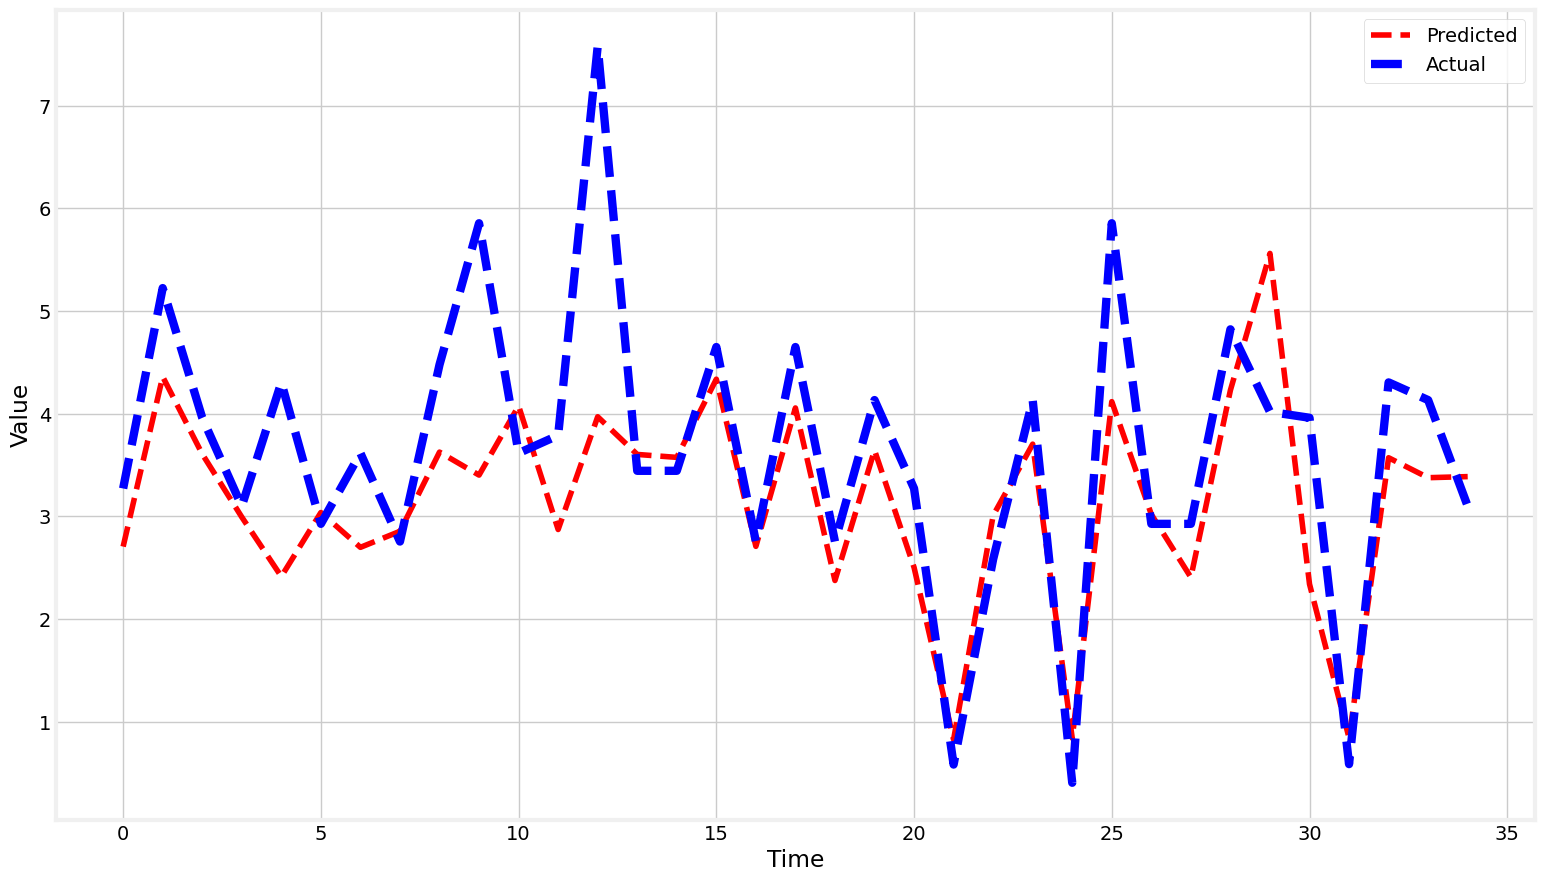

In [ ]:
predictions(y_train,y_test,y_pred)

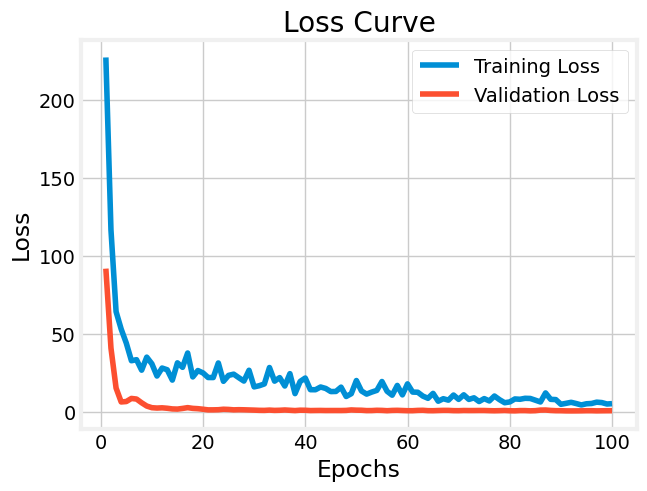

In [ ]:
plotCurves(history)

In [ ]:
train_loss = model.evaluate(x_train, y_train)
test_loss = model.evaluate(x_test, y_test)
print("Training Loss:", train_loss)
print("Testing Loss:", test_loss)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8794 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1197 
Training Loss: 0.9882976412773132
Testing Loss: 1.0978538990020752


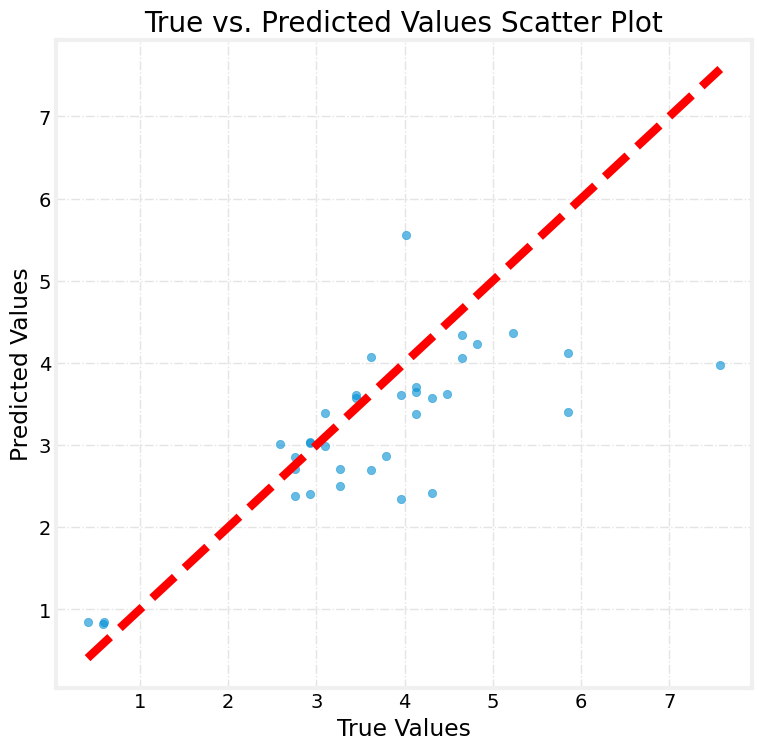

In [ ]:
plotPVT(y_test,y_pred)

# MLP model evaluation

In [ ]:
x_train_old, x_test_old, y_train_old, y_test_old = x_train, x_test, y_train, y_test

SVR

In [ ]:
model = make_pipeline(MinMaxScaler(), SVR())
model.fit(x_train_old,y_train_old)


y_pred = model.predict(x_test_old)
rmse_score = math.sqrt(np.mean(mean_squared_error(list(y_test_old), y_pred)))
mae_score = np.mean(mean_absolute_error(list(y_test_old), y_pred))
r2 = np.mean(r2_score(list(y_test_old), y_pred))
mape = np.mean(np.abs((list(y_test_old) - y_pred) / list(y_test_old)) * 100)
print("RMSE = ",rmse_score)
print("MAE = ",mae_score)
print("R2 = ",r2)
print("MAPE = ",mape)

RMSE =  0.8404600121251511
MAE =  0.5506787754566619
R2 =  0.5669770785188255
MAPE =  50.076703901054366


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


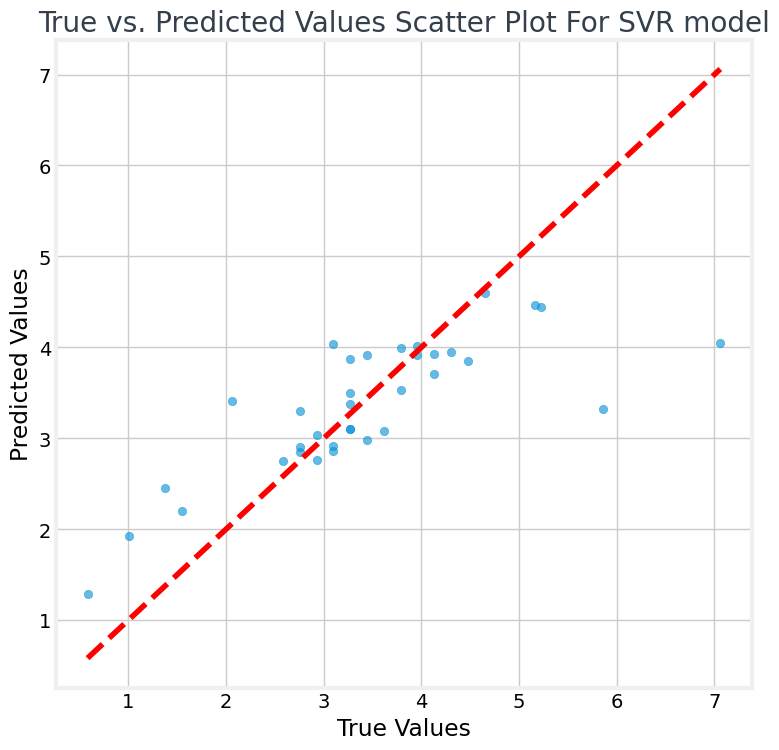

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(list(y_test_old), y_pred, alpha=0.6)
plt.plot([min(list(y_test_old)), max(list(y_test_old))], [min(list(y_test_old)), max(list(y_test_old))], color='red', linestyle='--', label='Diagonal Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values Scatter Plot For SVR model')
plt.savefig("svrTvP1.png", dpi = 200)
plt.show()

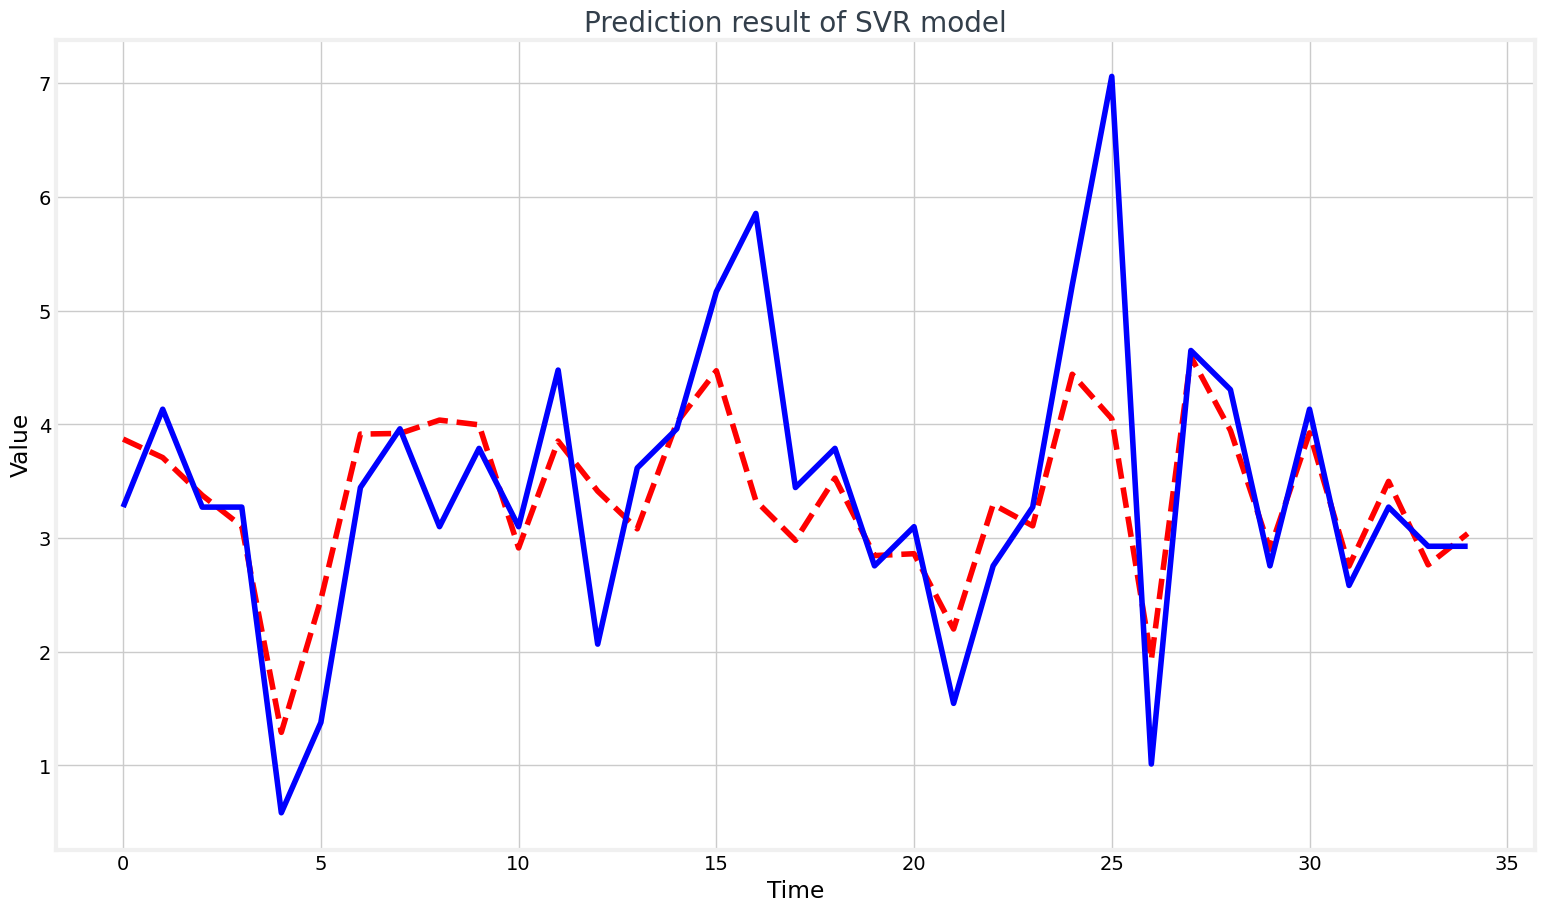

In [ ]:
plt.figure(figsize=(17,10))
y_t = list(y_test_old)
plt.plot(y_pred, color='red', linestyle='--',label='Predicted')
plt.plot(y_t, color='blue', linestyle='-',label='Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prediction result of SVR model')
plt.savefig("svr1.png", dpi=150)
plt.show()

GBR

In [ ]:
model = GradientBoostingRegressor(n_estimators=9, random_state=0)
model.fit(x_train_old, y_train_old)
y_pred = model.predict(x_test_old)
rmse_score = math.sqrt(np.mean(mean_squared_error(list(y_test_old), y_pred)))
mae_score = np.mean(mean_absolute_error(list(y_test_old), y_pred))
r2 = np.mean(r2_score(list(y_test_old), y_pred))
mape = np.mean(np.abs((list(y_test_old) - y_pred) / list(y_test_old)) * 100)
print("RMSE = ",rmse_score)
print("MAE = ",mae_score)
print("R2 = ",r2)
print("MAPE = ",mape)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE =  0.7760793570640127
MAE =  0.5920809188806894
R2 =  0.6307767514835116
MAPE =  51.02876293174861


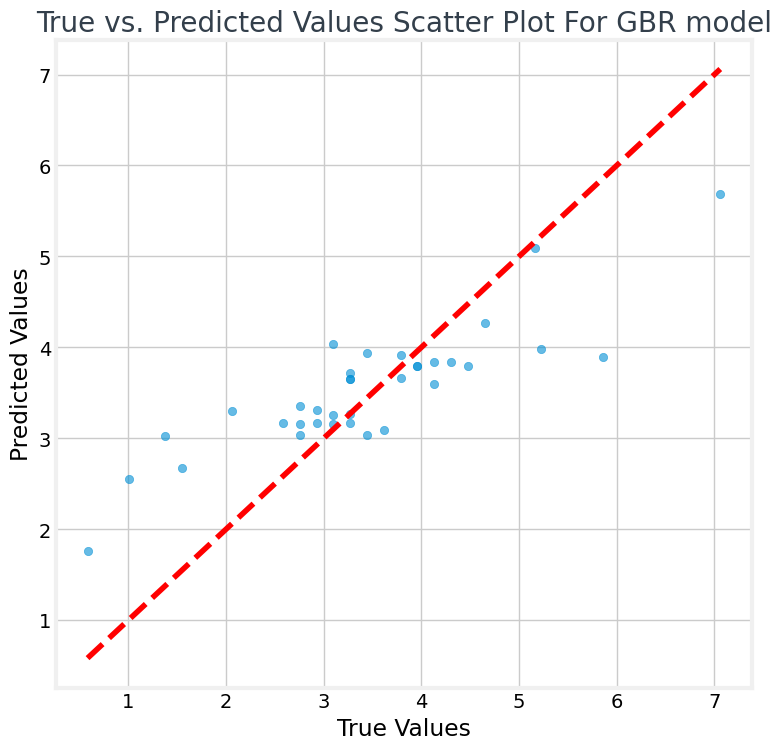

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(list(y_test_old), list(y_pred), alpha=0.6)
plt.plot([min(list(y_test_old)), max(list(y_test_old))], [min(list(y_test_old)), max(list(y_test_old))], color='red', linestyle='--', label='Diagonal Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values Scatter Plot For GBR model')
plt.savefig("gbrTvP1.png", dpi = 200)
plt.show()

DTR

In [ ]:
model = DecisionTreeRegressor(random_state=0)
model.fit(x_train_old, y_train_old)
y_pred = model.predict(x_test_old)
rmse_score = math.sqrt(np.mean(mean_squared_error(list(y_test_old), y_pred)))
mae_score = np.mean(mean_absolute_error(list(y_test_old), y_pred))
r2 = np.mean(r2_score(list(y_test_old), y_pred))
mape = np.mean(np.abs((list(y_test_old) - y_pred) / list(y_test_old)) * 100)
print("RMSE = ",rmse_score)
print("MAE = ",mae_score)
print("R2 = ",r2)
print("MAPE = ",mape)

RMSE =  0.8718543366909263
MAE =  0.6329559275537601
R2 =  0.5340228297929637
MAPE =  57.88256471338537


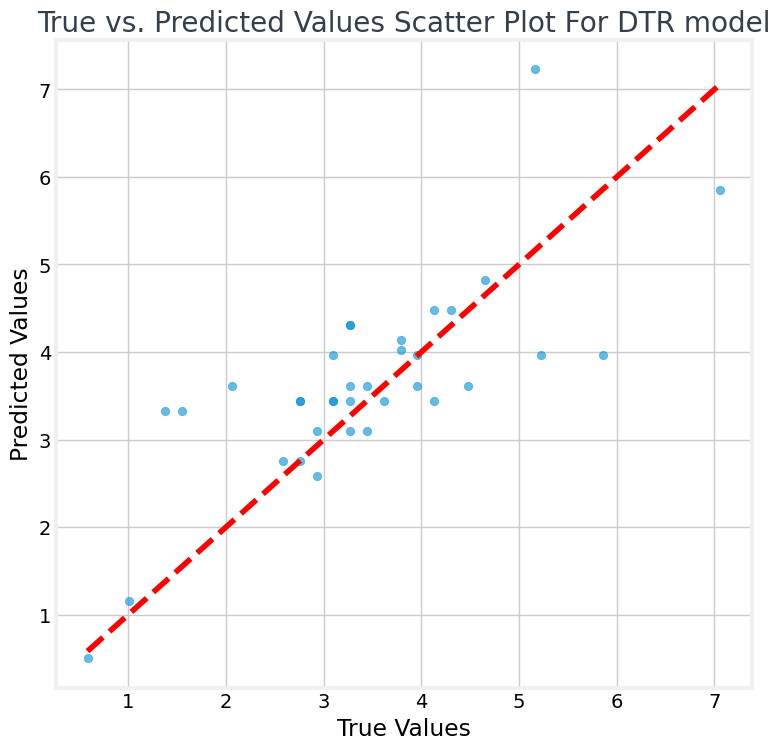

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(list(y_test_old), list(y_pred), alpha=0.6)
plt.plot([min(list(y_test_old)), max(list(y_test_old))], [min(list(y_test_old)), max(list(y_test_old))], color='red', linestyle='--', label='Diagonal Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values Scatter Plot For DTR model')
plt.savefig("dtrTvP.png", dpi = 200)
plt.show()

RFR

In [ ]:
model = RandomForestRegressor(max_depth=6)
model.fit(x_train_old, y_train_old)
y_pred = model.predict(x_test_old)
rmse_score = math.sqrt(np.mean(mean_squared_error(list(y_test_old), y_pred)))
mae_score = np.mean(mean_absolute_error(list(y_test_old), y_pred))
r2 = np.mean(r2_score(list(y_test_old), y_pred))
mape = np.mean(np.abs((list(y_test_old) - y_pred) / list(y_test_old)) * 100)
print("RMSE = ",rmse_score)
print("MAE = ",mae_score)
print("R2 = ",r2)
print("MAPE = ",mape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE =  0.6916662244966566
MAE =  0.4818286401337416
R2 =  0.706728464660451
MAPE =  53.12686938419724


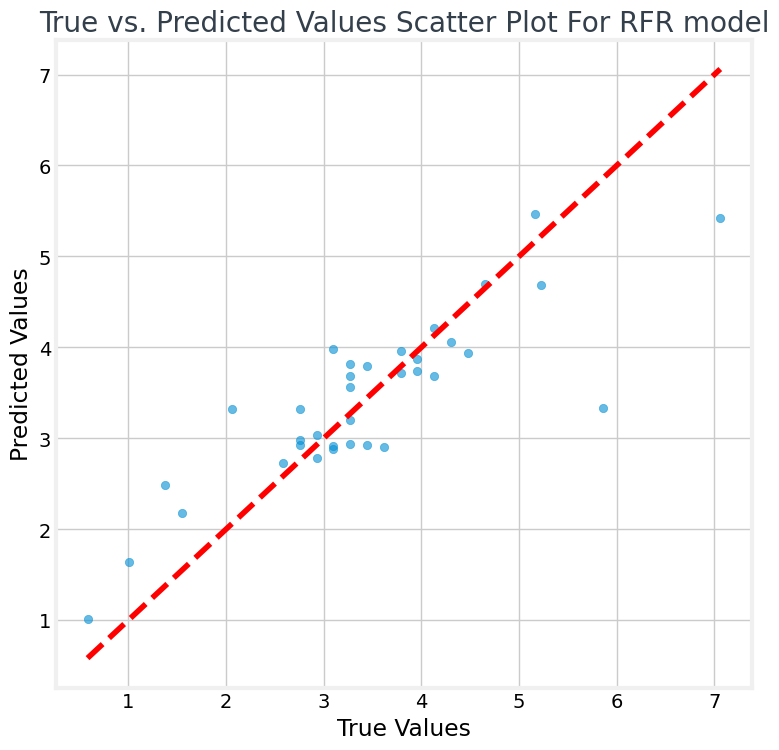

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(list(y_test_old), list(y_pred), alpha=0.6)
plt.plot([min(list(y_test_old)), max(list(y_test_old))], [min(list(y_test_old)), max(list(y_test_old))], color='red', linestyle='--', label='Diagonal Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values Scatter Plot For RFR model')
plt.savefig("rfrTvP1.png", dpi = 200)
plt.show()

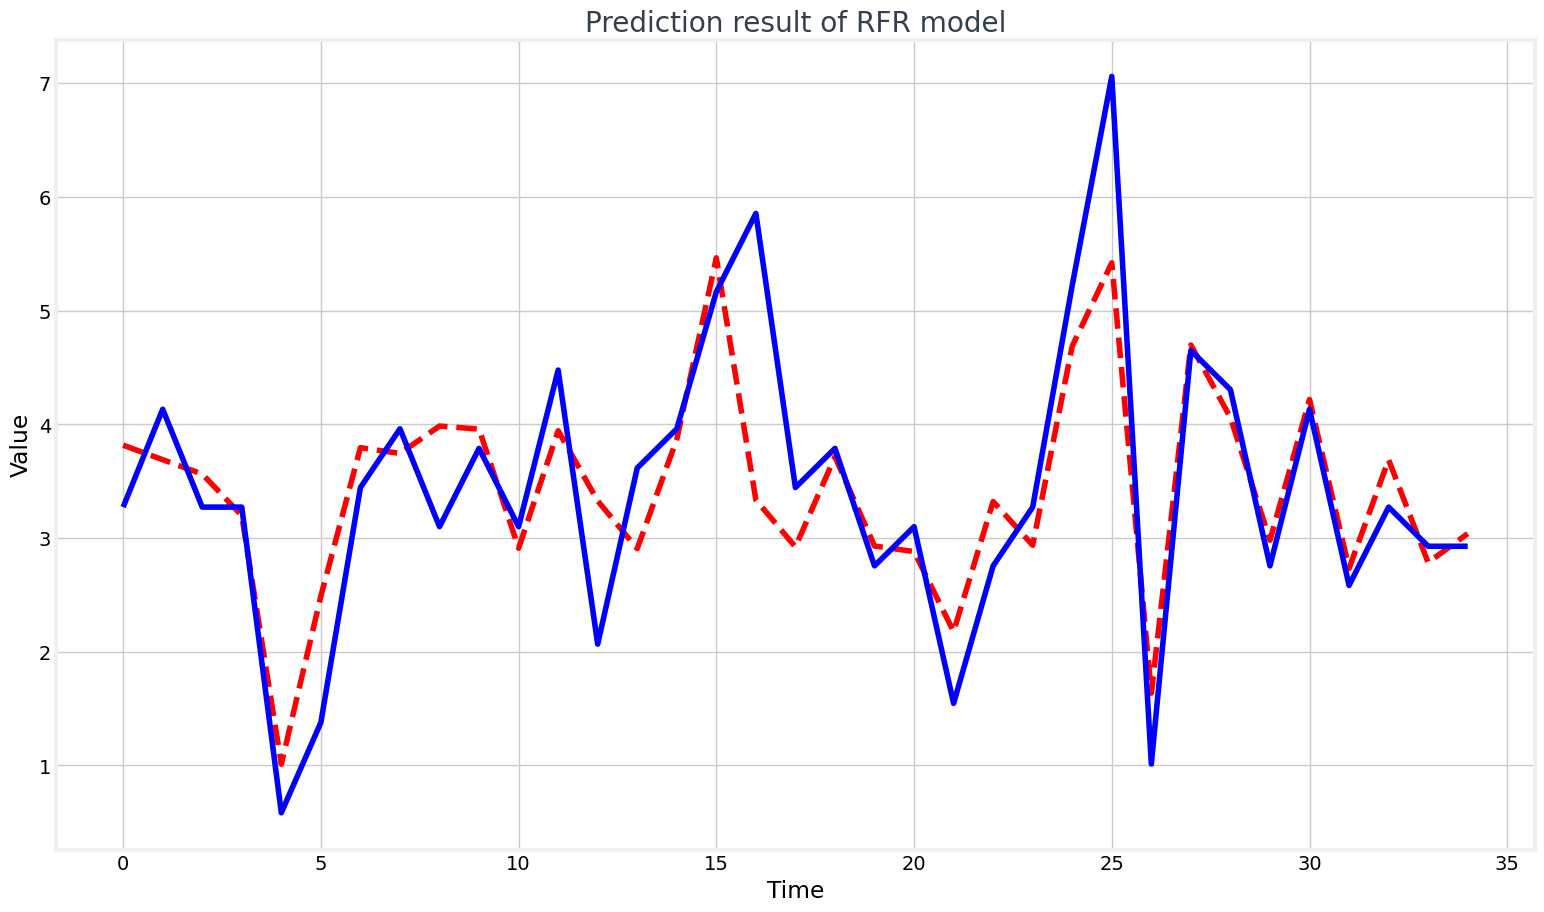

In [ ]:
plt.figure(figsize=(17,10))
y_t = list(y_test_old)
plt.plot(y_pred, color='red', linestyle='--',label='Predicted')
plt.plot(y_t, color='blue', linestyle='-',label='Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prediction result of RFR model')
plt.savefig("rfr.png", dpi=150)
plt.show()

RNN

Epoch 1/100
3/3 - 2s - 542ms/step - loss: 2.9995
Epoch 2/100
3/3 - 0s - 18ms/step - loss: 1.4214
Epoch 3/100
3/3 - 0s - 21ms/step - loss: 0.9604
Epoch 4/100
3/3 - 0s - 19ms/step - loss: 0.9087
Epoch 5/100
3/3 - 0s - 17ms/step - loss: 0.7272
Epoch 6/100
3/3 - 0s - 23ms/step - loss: 0.6944
Epoch 7/100
3/3 - 0s - 20ms/step - loss: 0.6925
Epoch 8/100
3/3 - 0s - 17ms/step - loss: 0.6117
Epoch 9/100
3/3 - 0s - 19ms/step - loss: 0.5709
Epoch 10/100
3/3 - 0s - 20ms/step - loss: 0.5766
Epoch 11/100
3/3 - 0s - 19ms/step - loss: 0.5556
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 0.5301
Epoch 13/100
3/3 - 0s - 19ms/step - loss: 0.5256
Epoch 14/100
3/3 - 0s - 25ms/step - loss: 0.5164
Epoch 15/100
3/3 - 0s - 45ms/step - loss: 0.5008
Epoch 16/100
3/3 - 0s - 21ms/step - loss: 0.4980
Epoch 17/100
3/3 - 0s - 48ms/step - loss: 0.4904
Epoch 18/100
3/3 - 0s - 48ms/step - loss: 0.4935
Epoch 19/100
3/3 - 0s - 50ms/step - loss: 0.4861
Epoch 20/100
3/3 - 0s - 23ms/step - loss: 0.4787
Epoch 21/100
3/3 - 0s - 47ms

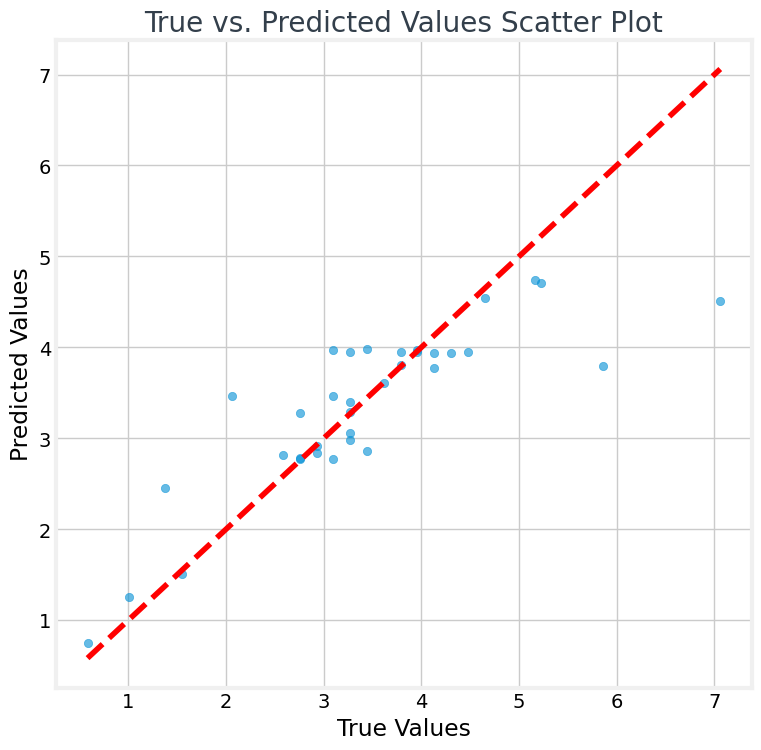

In [ ]:
x_tr_old = x_train_old.reshape((x_train_old.shape[0], 1, x_train_old.shape[1]))
x_t_old = x_test_old.reshape((x_test_old.shape[0], 1, x_test_old.shape[1]))


#x_tr_old = np.array(prep_X(x_train_old, 1))
#x_t_old = np.array(prep_X(x_test_old, 1))
y_tr_old = np.array(y_train_old)
y_t_old = np.array(y_test_old)


rnns = Sequential()
rnns.add(Input(shape=(1,1949)))
rnns.add(SimpleRNN(128,activation = 'tanh'))
#rnns.add(Dense(128,activation = 'relu'))
rnns.add(Dense(1))

rnns.compile(loss='mean_absolute_error', optimizer='adam')
#generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=t, batch_size=32)
# Fitting the rnn to the Training set
rnns.fit(x_tr_old, y_tr_old, batch_size = 32, shuffle = True, epochs=100, verbose = 2)
#test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=t, batch_size=32)
y_pred_old2 = rnns.predict(x_t_old)

mae = np.mean(mean_absolute_error(y_t_old,y_pred_old2))
rmse = math.sqrt(np.mean(mean_squared_error(y_t_old,y_pred_old2)))
r2 = np.mean(r2_score(list(y_t_old), y_pred_old2))
mape = np.mean(np.abs((list(y_t_old) - y_pred_old2) / list(y_t_old)) * 100)
print("---------------------------------")
print("RMSE = ",rmse_score)
print("MAE = ",mae_score)
print("R2 = ",r2)
print("MAPE = ",mape)

plt.figure(figsize=(8, 8))
plt.scatter(y_t_old, y_pred_old2, alpha=0.6)
plt.plot([min(y_t_old), max(y_t_old)], [min(y_t_old), max(y_t_old)], color='red', linestyle='--', label='Diagonal Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values Scatter Plot')
plt.savefig("rnnTvP.png", dpi = 200)
plt.show()

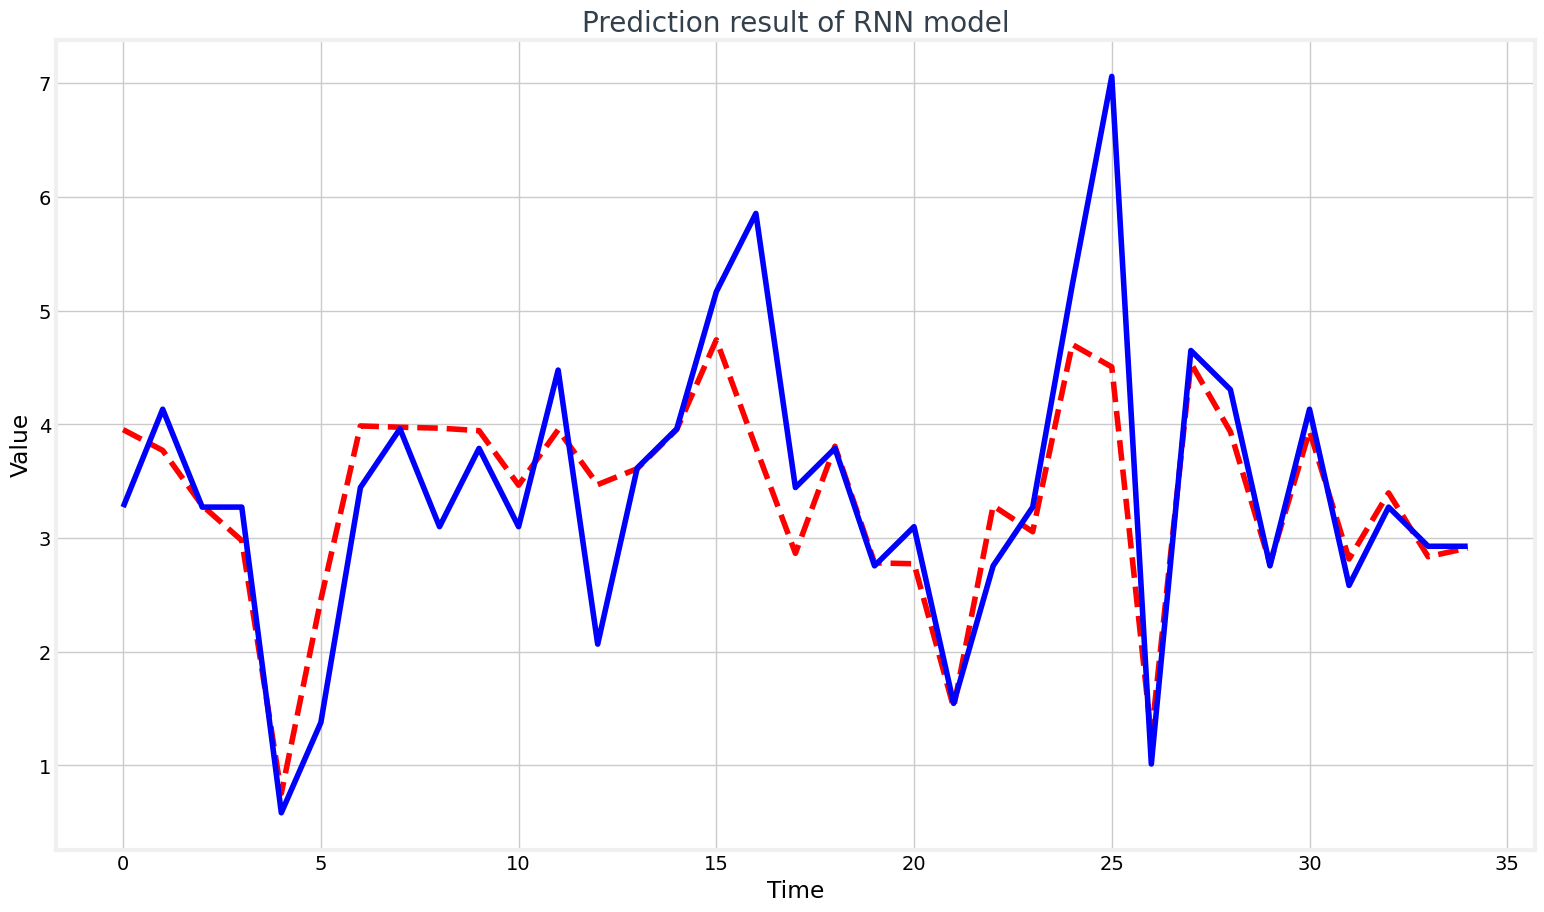

In [ ]:
plt.figure(figsize=(17,10))
y_t = list(y_t_old)
plt.plot(y_pred_old2, color='red', linestyle='--',label='Predicted')
plt.plot(y_t, color='blue', linestyle='-',label='Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prediction result of RNN model')
plt.savefig("rnn1.png", dpi=150)
plt.show()

LSTM

Epoch 1/100
3/3 - 3s - 933ms/step - loss: 3.7964
Epoch 2/100
3/3 - 0s - 34ms/step - loss: 1.0678
Epoch 3/100
3/3 - 0s - 50ms/step - loss: 0.8504
Epoch 4/100
3/3 - 0s - 63ms/step - loss: 0.9362
Epoch 5/100
3/3 - 0s - 36ms/step - loss: 0.7985
Epoch 6/100
3/3 - 0s - 34ms/step - loss: 0.7487
Epoch 7/100
3/3 - 0s - 44ms/step - loss: 0.7316
Epoch 8/100
3/3 - 0s - 49ms/step - loss: 0.5655
Epoch 9/100
3/3 - 0s - 37ms/step - loss: 0.6308
Epoch 10/100
3/3 - 0s - 45ms/step - loss: 0.5335
Epoch 11/100
3/3 - 0s - 43ms/step - loss: 0.5408
Epoch 12/100
3/3 - 0s - 39ms/step - loss: 0.6375
Epoch 13/100
3/3 - 0s - 48ms/step - loss: 0.5226
Epoch 14/100
3/3 - 0s - 38ms/step - loss: 0.5328
Epoch 15/100
3/3 - 0s - 44ms/step - loss: 0.5593
Epoch 16/100
3/3 - 0s - 37ms/step - loss: 0.5163
Epoch 17/100
3/3 - 0s - 42ms/step - loss: 0.5071
Epoch 18/100
3/3 - 0s - 48ms/step - loss: 0.5000
Epoch 19/100
3/3 - 0s - 40ms/step - loss: 0.4860
Epoch 20/100
3/3 - 0s - 19ms/step - loss: 0.4915
Epoch 21/100
3/3 - 0s - 19ms

---------------------------------
RMSE =  0.6916662244966566
MAE =  0.4818286401337416
R2 =  0.691521670276295
MAPE =  13.22060048016832


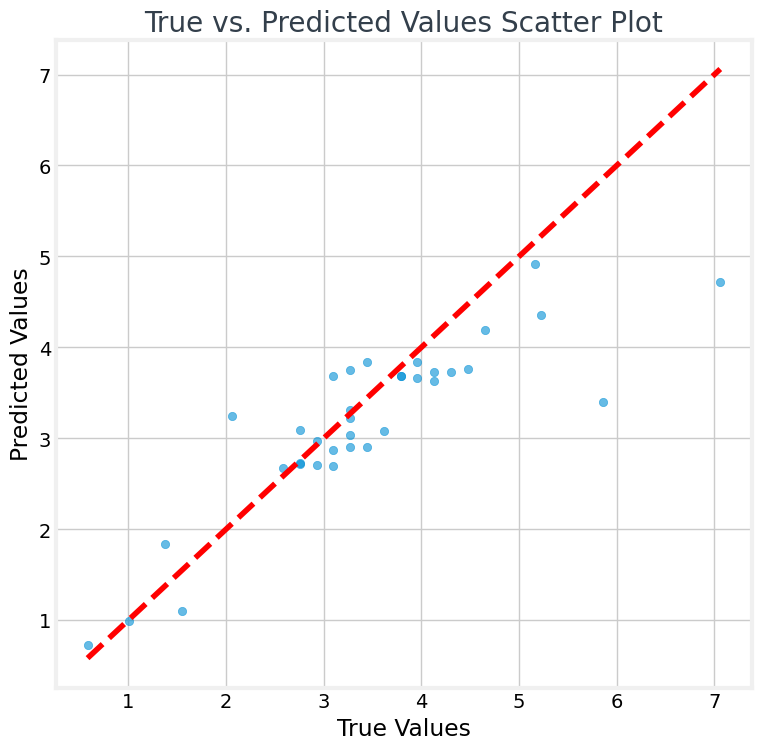

In [ ]:
lstm = Sequential()
lstm.add(Input(shape=(1,1949)))
lstm.add(LSTM(128,activation = 'relu'))
#lstm.add(Dense(128,activation = 'relu'))
lstm.add(Dense(1))

lstm.compile(loss='mean_absolute_error', optimizer='adam')
#generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=t, batch_size=32)
# Fitting the rnn to the Training set
lstm.fit(x_tr_old, y_tr_old, batch_size = 32, shuffle = True, epochs=100, verbose = 2)
#test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=t, batch_size=32)
y_pred_old2 = lstm.predict(x_t_old)

mae = np.mean(mean_absolute_error(y_t_old,y_pred_old2))
rmse = math.sqrt(np.mean(mean_squared_error(y_t_old,y_pred_old2)))
r2 = np.mean(r2_score(list(y_t_old), y_pred_old2))
mape = np.mean(np.abs((list(y_t_old) - y_pred_old2) / list(y_t_old)) * 100)
print("---------------------------------")
print("RMSE = ",rmse_score)
print("MAE = ",mae_score)
print("R2 = ",r2)
print("MAPE = ",mape)

plt.figure(figsize=(8, 8))
plt.scatter(y_t_old, y_pred_old2, alpha=0.6)
plt.plot([min(y_t_old), max(y_t_old)], [min(y_t_old), max(y_t_old)], color='red', linestyle='--', label='Diagonal Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values Scatter Plot')
plt.savefig("lstmTvP1.png", dpi = 200)
plt.show()

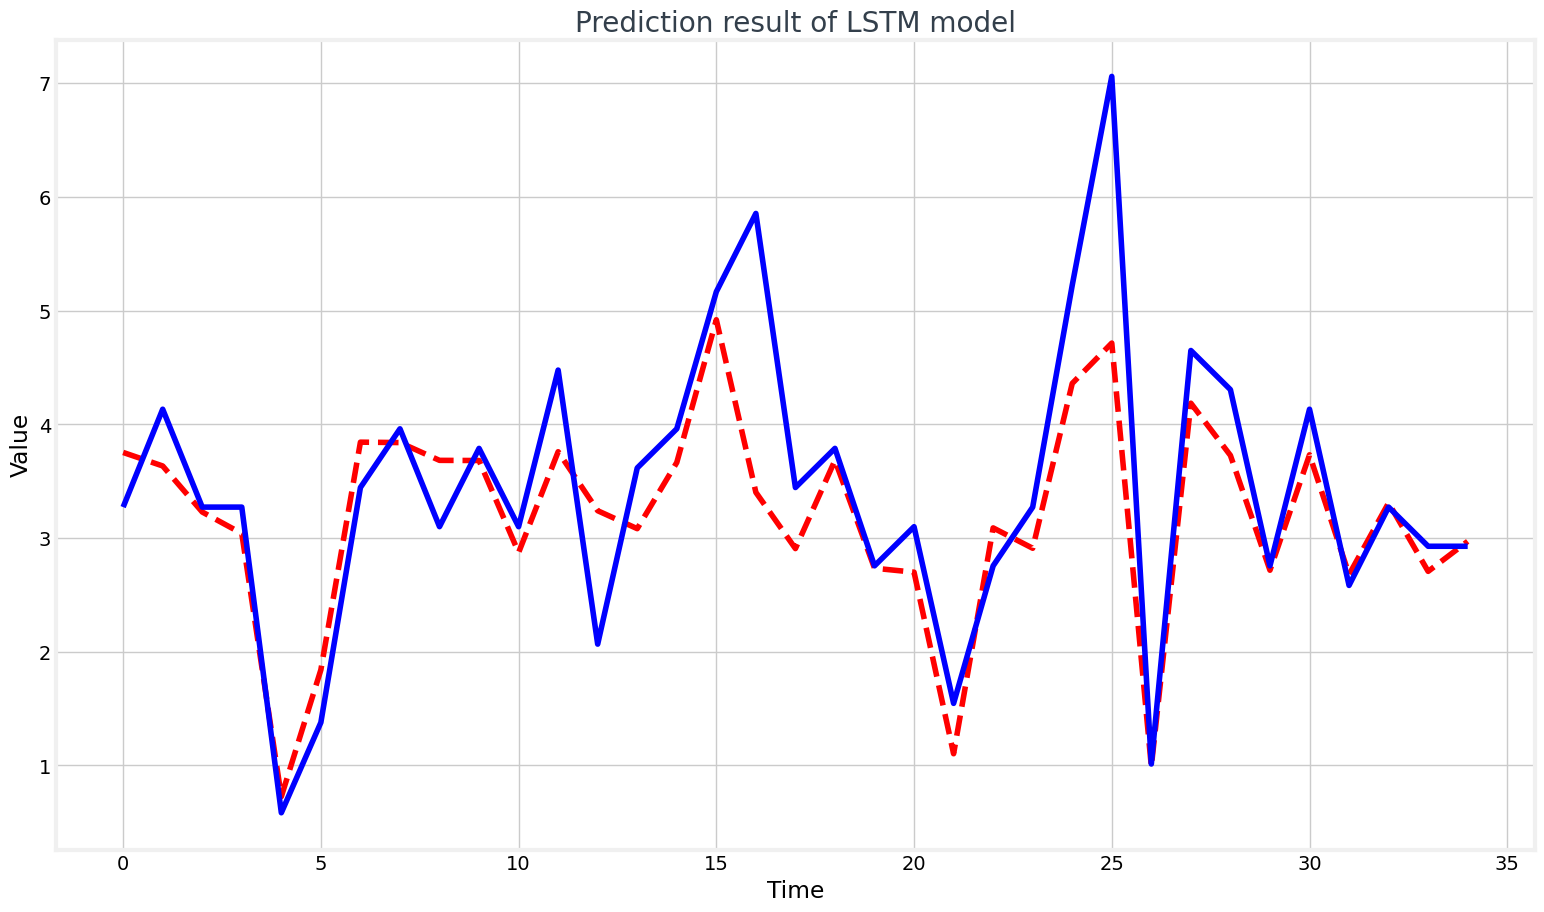

In [ ]:
plt.figure(figsize=(17,10))
y_t = list(y_t_old)
plt.plot(y_pred_old2, color='red', linestyle='--',label='Predicted')
plt.plot(y_t, color='blue', linestyle='-',label='Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prediction result of LSTM model')
plt.savefig("lstm1.png", dpi=150)
plt.show()

# Proposed approach evaluation

In [ ]:
data_old = pd.read_csv("Output.csv")
data_old = data_old.dropna(axis=0)
data_old = data_old.drop(['Unnamed: 0','Daily Temperature','Daily Wind','Daily Humidity','Daily Cumulative UV'], axis = 1)
data_old = data_old.reset_index()
data_old.describe()

,index,Daily Cumulative Light,Daily GH Temperature,Daily GH Humidity,Daily Ventilation Wind,Daily Pipe Low,Daily Pipe Grow,Daily Humedity Deficit,Daily CO2 emission,pH_Drain,EC_Drain,water
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,114.359649,722.236842,23.002057,79.566566,5.619028,23.151297,20.266902,4.369308,771.455519,5.669470,3.057702,3.510987
std,66.814903,17.555351,1.447409,6.042575,10.497899,9.688967,9.995479,1.509954,200.840665,1.735290,1.873327,1.309945
min,0.000000,525.000000,19.273793,48.108966,0.000000,0.000000,0.000000,2.225103,401.534483,0.010210,0.050000,0.406125
25%,56.750000,725.000000,21.939655,77.799655,0.622759,22.627931,17.418793,3.431207,607.396552,5.779132,1.721146,2.927400
50%,113.500000,725.000000,23.141724,81.545915,2.210690,26.364828,24.472414,3.863795,778.905172,6.131111,2.685686,3.444000
75%,172.250000,725.000000,24.083276,83.296724,4.943621,28.887500,27.431552,4.664069,968.463793,6.638906,4.169375,4.132800
max,229.000000,725.000000,26.324060,89.853793,64.122069,35.651724,32.239310,13.570276,1070.924138,6.805417,7.433490,7.921200


In [ ]:
Y_old = data_old.iloc[ :, -1:]
data_old.pop(data_old.columns[-1])

scaler = MinMaxScaler(feature_range=(0, 1))

X_old = scaler.fit_transform(data_old)

x_train_old, x_test_old, y_train_old, y_test_old = train_test_split(X_old,Y_old, shuffle=True, test_size=0.3)
y_test_old = list(y_test_old['water'])
#print (y_test_old)

SVR

In [ ]:
model = make_pipeline(MinMaxScaler(), SVR())
model.fit(x_train_old,y_train_old)


y_pred = model.predict(x_test_old)
rmse_score = math.sqrt(np.mean(mean_squared_error(list(y_test_old), y_pred)))
mae_score = np.mean(mean_absolute_error(list(y_test_old), y_pred))
r2 = np.mean(r2_score(list(y_test_old), y_pred))
mape = np.mean(np.abs((list(y_test_old) - y_pred) / list(y_test_old)) * 100)
print("RMSE = ",rmse_score)
print("MAE = ",mae_score)
print("R2 = ",r2)
print("MAPE = ",mape)

RMSE =  0.8162835266479287
MAE =  0.5421105012102436
R2 =  0.6589623490564203
MAPE =  16.411285235402385


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


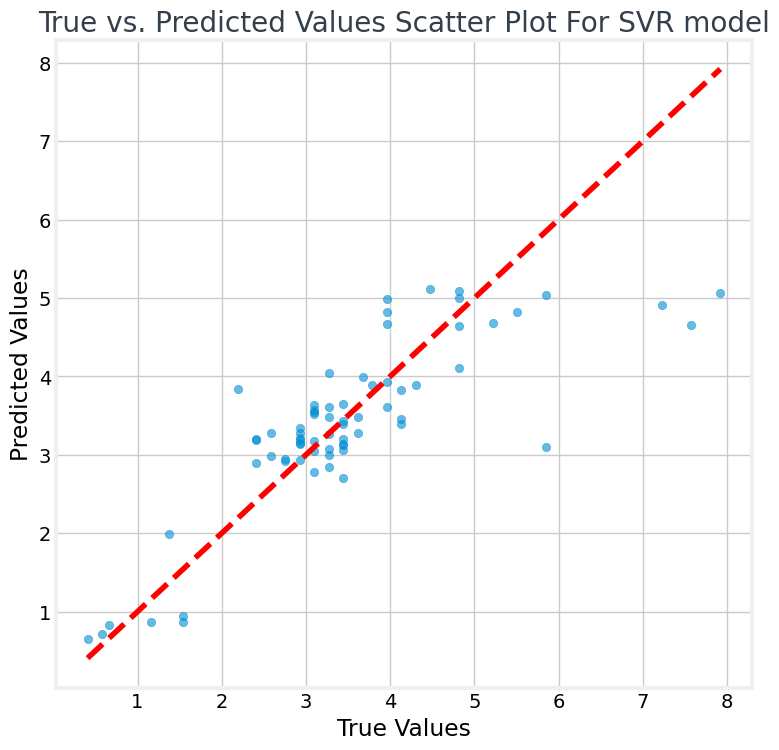

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(list(y_test_old), y_pred, alpha=0.6)
plt.plot([min(list(y_test_old)), max(list(y_test_old))], [min(list(y_test_old)), max(list(y_test_old))], color='red', linestyle='--', label='Diagonal Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values Scatter Plot For SVR model')
plt.savefig("svrTvP2.png", dpi = 200)
plt.show()

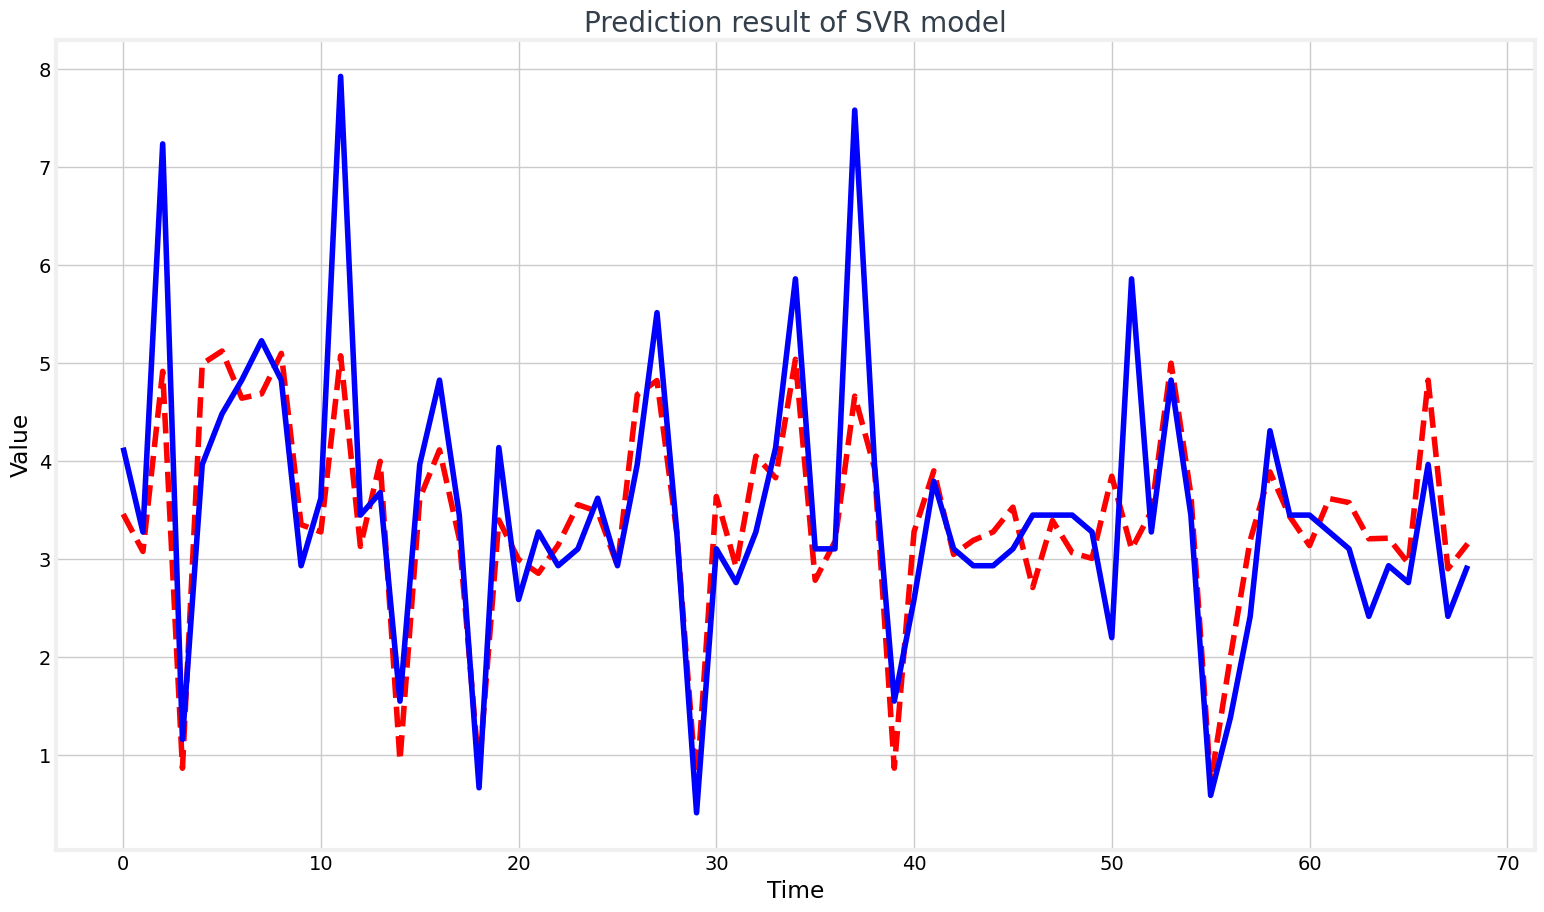

In [ ]:
plt.figure(figsize=(17,10))
y_t = list(y_test_old)
plt.plot(y_pred, color='red', linestyle='--',label='Predicted')
plt.plot(y_t, color='blue', linestyle='-',label='Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prediction result of SVR model')
plt.savefig("svr2.png", dpi=150)
plt.show()

RFR

In [ ]:
model = RandomForestRegressor()
model.fit(x_train_old, y_train_old)
y_pred = model.predict(x_test_old)
rmse_score = math.sqrt(np.mean(mean_squared_error(list(y_test_old), y_pred)))
mae_score = np.mean(mean_absolute_error(list(y_test_old), y_pred))
r2 = np.mean(r2_score(list(y_test_old), y_pred))
mape = np.mean(np.abs((list(y_test_old) - y_pred) / list(y_test_old)) * 100)
print("RMSE = ",rmse_score)
print("MAE = ",mae_score)
print("R2 = ",r2)
print("MAPE = ",mape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE =  0.6873899586673177
MAE =  0.4650167103869518
R2 =  0.7581608368187894
MAPE =  14.653691877936673


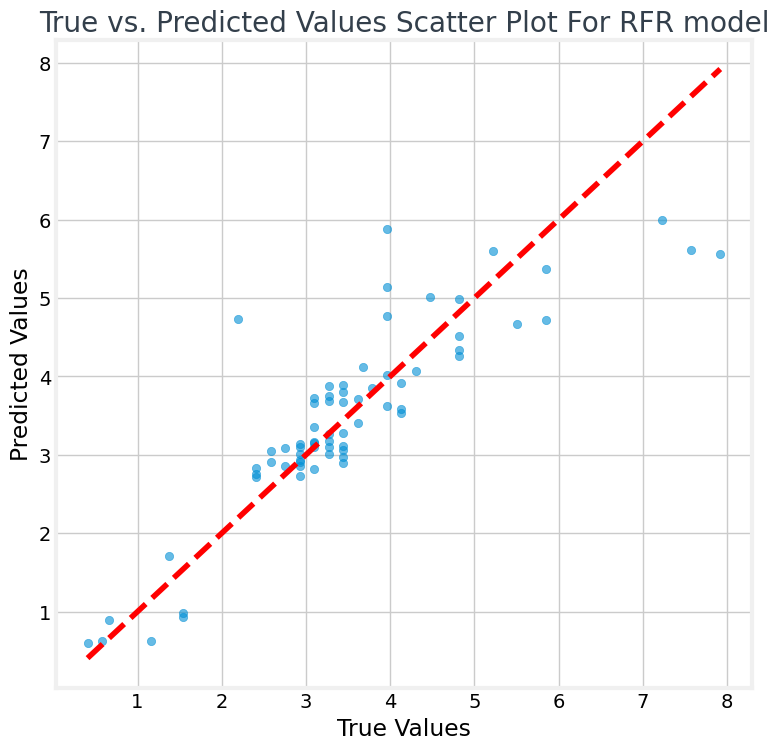

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(list(y_test_old), list(y_pred), alpha=0.6)
plt.plot([min(list(y_test_old)), max(list(y_test_old))], [min(list(y_test_old)), max(list(y_test_old))], color='red', linestyle='--', label='Diagonal Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values Scatter Plot For RFR model')
plt.savefig("rfrTvP2.png", dpi = 200)
plt.show()

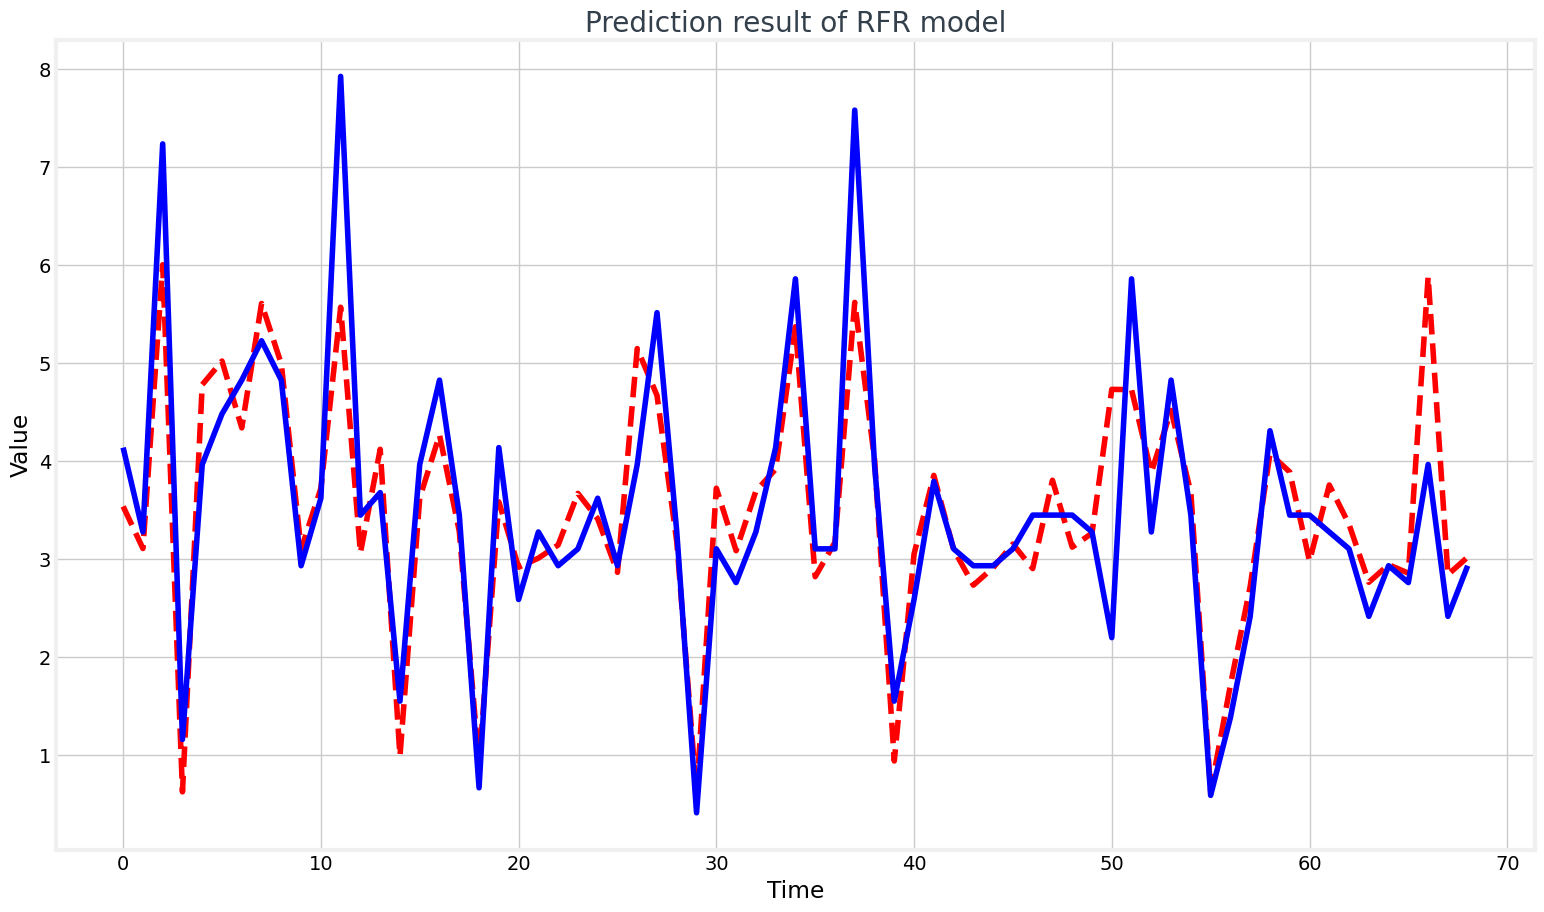

In [ ]:
plt.figure(figsize=(17,10))
y_t = list(y_test_old)
plt.plot(y_pred, color='red', linestyle='--',label='Predicted')
plt.plot(y_t, color='blue', linestyle='-',label='Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prediction result of RFR model')
plt.savefig("rfr2.png", dpi=150)
plt.show()

GBR

In [ ]:
model = GradientBoostingRegressor(n_estimators=9, random_state=0)
model.fit(x_train_old, y_train_old)
y_pred = model.predict(x_test_old)
rmse_score = math.sqrt(np.mean(mean_squared_error(list(y_test_old), y_pred)))
mae_score = np.mean(mean_absolute_error(list(y_test_old), y_pred))
r2 = np.mean(r2_score(list(y_test_old), y_pred))
mape = np.mean(np.abs((list(y_test_old) - y_pred) / list(y_test_old)) * 100)
print("RMSE = ",rmse_score)
print("MAE = ",mae_score)
print("R2 = ",r2)
print("MAPE = ",mape)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE =  0.8790587980396479
MAE =  0.5958073874378885
R2 =  0.6044912337824144
MAPE =  25.512633345188167


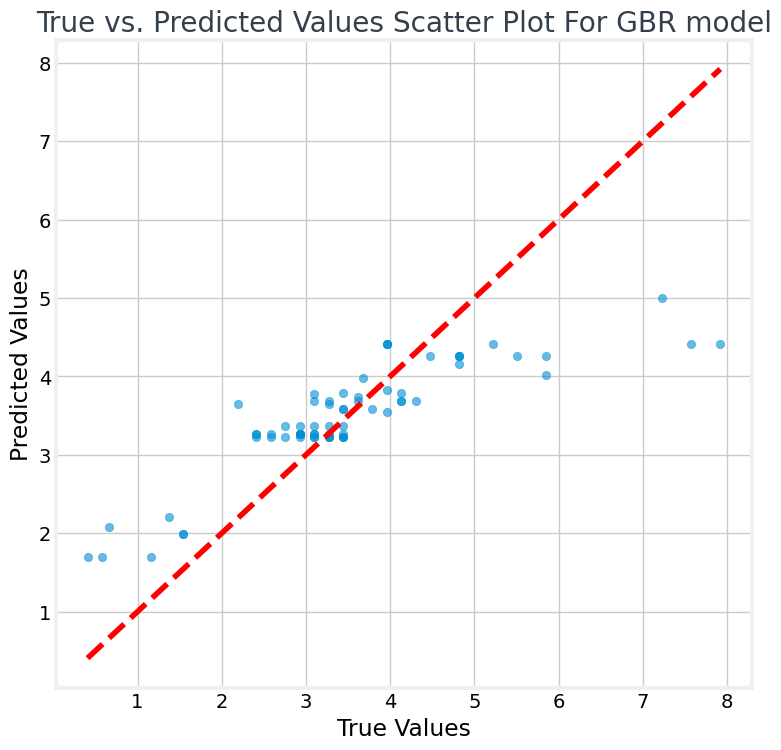

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(list(y_test_old), list(y_pred), alpha=0.6)
plt.plot([min(list(y_test_old)), max(list(y_test_old))], [min(list(y_test_old)), max(list(y_test_old))], color='red', linestyle='--', label='Diagonal Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values Scatter Plot For GBR model')
plt.savefig("gbrTvP2.png", dpi = 200)
plt.show()

DTR

In [ ]:
model = DecisionTreeRegressor(random_state=0)
model.fit(x_train_old, y_train_old)
y_pred = model.predict(x_test_old)
rmse_score = math.sqrt(np.mean(mean_squared_error(list(y_test_old), y_pred)))
mae_score = np.mean(mean_absolute_error(list(y_test_old), y_pred))
r2 = np.mean(r2_score(list(y_test_old), y_pred))
mape = np.mean(np.abs((list(y_test_old) - y_pred) / list(y_test_old)) * 100)
print("RMSE = ",rmse_score)
print("MAE = ",mae_score)
print("R2 = ",r2)
print("MAPE = ",mape)

RMSE =  0.7439648077352203
MAE =  0.4340463596055018
R2 =  0.7167140414846327
MAPE =  13.397665064521414


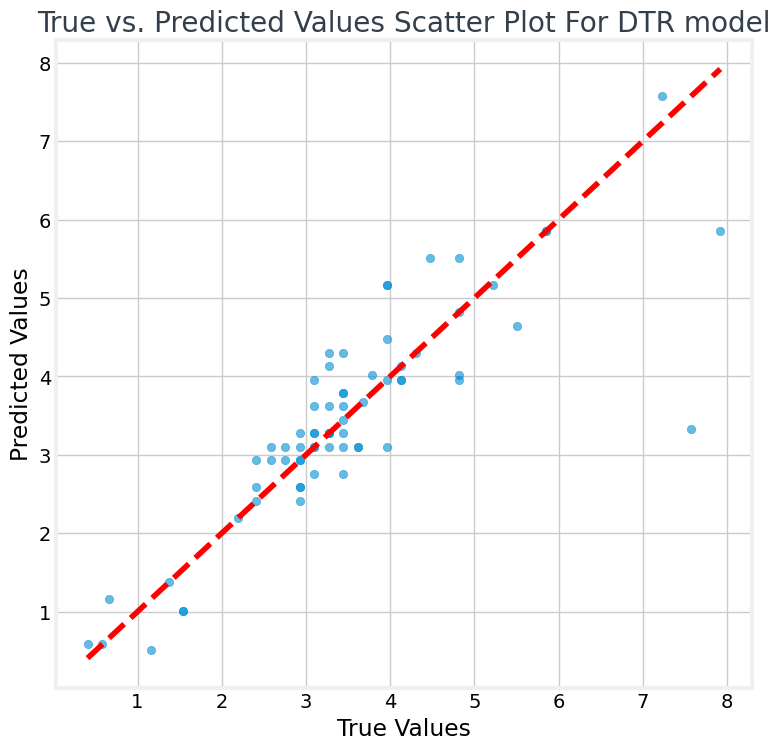

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(list(y_test_old), list(y_pred), alpha=0.6)
plt.plot([min(list(y_test_old)), max(list(y_test_old))], [min(list(y_test_old)), max(list(y_test_old))], color='red', linestyle='--', label='Diagonal Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values Scatter Plot For DTR model')
plt.savefig("dtrTvP2.png", dpi = 200)
plt.show()

ANN

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
5/5 - 1s - 277ms/step - loss: 3.7599
Epoch 2/100
5/5 - 0s - 12ms/step - loss: 3.4218
Epoch 3/100
5/5 - 0s - 8ms/step - loss: 3.0898
Epoch 4/100
5/5 - 0s - 8ms/step - loss: 2.7602
Epoch 5/100
5/5 - 0s - 12ms/step - loss: 2.4277
Epoch 6/100
5/5 - 0s - 9ms/step - loss: 2.0956
Epoch 7/100
5/5 - 0s - 9ms/step - loss: 1.7553
Epoch 8/100
5/5 - 0s - 12ms/step - loss: 1.4105
Epoch 9/100
5/5 - 0s - 8ms/step - loss: 1.1143
Epoch 10/100
5/5 - 0s - 8ms/step - loss: 0.9202
Epoch 11/100
5/5 - 0s - 12ms/step - loss: 0.8373
Epoch 12/100
5/5 - 0s - 8ms/step - loss: 0.8540
Epoch 13/100
5/5 - 0s - 8ms/step - loss: 0.8565
Epoch 14/100
5/5 - 0s - 8ms/step - loss: 0.8427
Epoch 15/100
5/5 - 0s - 8ms/step - loss: 0.8180
Epoch 16/100
5/5 - 0s - 9ms/step - loss: 0.7949
Epoch 17/100
5/5 - 0s - 8ms/step - loss: 0.7784
Epoch 18/100
5/5 - 0s - 8ms/step - loss: 0.7658
Epoch 19/100
5/5 - 0s - 9ms/step - loss: 0.7511
Epoch 20/100
5/5 - 0s - 8ms/step - loss: 0.7383
Epoch 21/100
5/5 - 0s - 8ms/step - loss: 0.

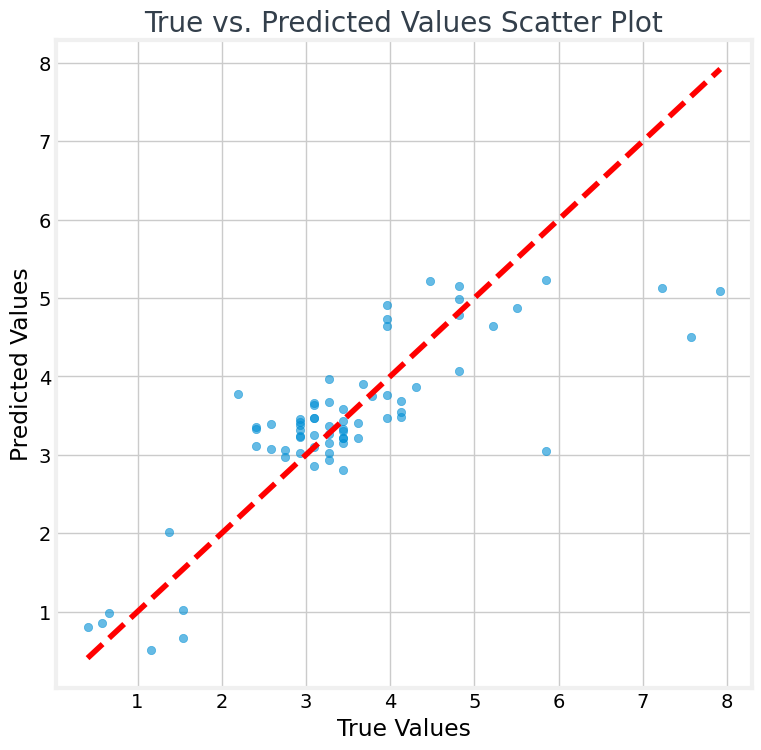

In [ ]:

ann = Sequential()
ann.add(InputLayer(input_shape=(11,)))
ann.add(Dense(128,activation = 'relu'))
ann.add(Dense(1))

ann.compile(loss='mean_absolute_error', optimizer='adam')
#generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=t, batch_size=32)
# Fitting the ANN to the Training set
ann.fit(x_train_old, y_train_old, batch_size = 32, shuffle = True, epochs=100, verbose = 2)
#test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=t, batch_size=32)
y_pred_old = ann.predict(x_test_old)

mae = np.mean(mean_absolute_error(y_test_old,y_pred_old))
rmse = math.sqrt(np.mean(mean_squared_error(y_test_old,y_pred_old)))
r2 = np.mean(r2_score(list(y_test_old), y_pred_old))
mape = np.mean(np.abs((list(y_test_old) - y_pred_old) / list(y_test_old)) * 100)
print("---------------------------------")
print("RMSE = ",rmse_score)
print("MAE = ",mae_score)
print("R2 = ",r2)
print("MAPE = ",mape)
plt.figure(figsize=(8, 8))
plt.scatter(list(y_test_old), list(y_pred_old), alpha=0.6)
plt.plot([min(list(y_test_old)), max(list(y_test_old))], [min(list(y_test_old)), max(list(y_test_old))], color='red', linestyle='--', label='Diagonal Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values Scatter Plot')
plt.savefig("annTvP2.png", dpi = 200)
plt.show()

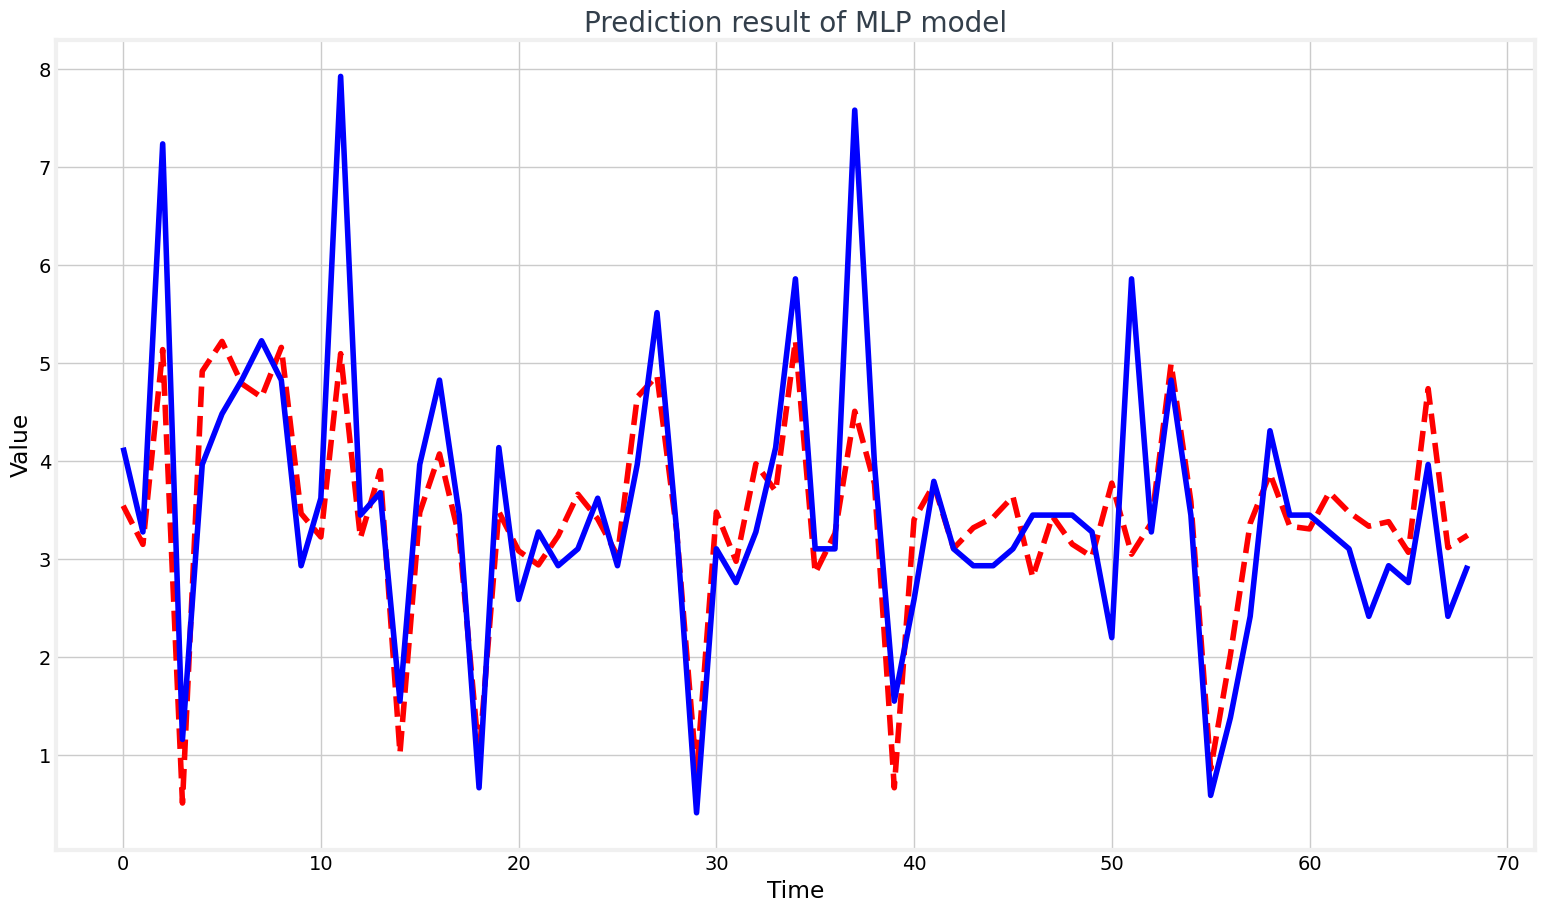

In [ ]:
plt.figure(figsize=(17,10))
y_t = list(y_test_old)
plt.plot(y_pred_old, color='red', linestyle='--',label='Predicted')
plt.plot(y_t, color='blue', linestyle='-',label='Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prediction result of MLP model')
plt.savefig("ann2.png", dpi=150)
plt.show()

RNN

Epoch 1/100
5/5 - 0s - 59ms/step - loss: 3.3194
Epoch 2/100
5/5 - 0s - 52ms/step - loss: 2.9424
Epoch 3/100
5/5 - 0s - 60ms/step - loss: 2.5918
Epoch 4/100
5/5 - 0s - 59ms/step - loss: 2.2282
Epoch 5/100
5/5 - 0s - 60ms/step - loss: 1.8703
Epoch 6/100
5/5 - 0s - 55ms/step - loss: 1.5026
Epoch 7/100
5/5 - 0s - 57ms/step - loss: 1.2108
Epoch 8/100
5/5 - 0s - 73ms/step - loss: 1.0866
Epoch 9/100
5/5 - 1s - 120ms/step - loss: 1.0512
Epoch 10/100
5/5 - 1s - 133ms/step - loss: 1.0808
Epoch 11/100
5/5 - 1s - 122ms/step - loss: 1.0688
Epoch 12/100
5/5 - 0s - 81ms/step - loss: 1.0420
Epoch 13/100
5/5 - 0s - 98ms/step - loss: 1.0360
Epoch 14/100
5/5 - 0s - 55ms/step - loss: 1.0312
Epoch 15/100
5/5 - 0s - 65ms/step - loss: 1.0253
Epoch 16/100
5/5 - 0s - 51ms/step - loss: 1.0209
Epoch 17/100
5/5 - 0s - 63ms/step - loss: 1.0136
Epoch 18/100
5/5 - 0s - 85ms/step - loss: 1.0102
Epoch 19/100
5/5 - 0s - 82ms/step - loss: 1.0072
Epoch 20/100
5/5 - 0s - 97ms/step - loss: 1.0037
Epoch 21/100
5/5 - 0s - 51

---------------------------------
RMSE =  0.7439648077352203
MAE =  0.4340463596055018
R2 =  -0.041022337196573444
MAPE =  53.49647047383603


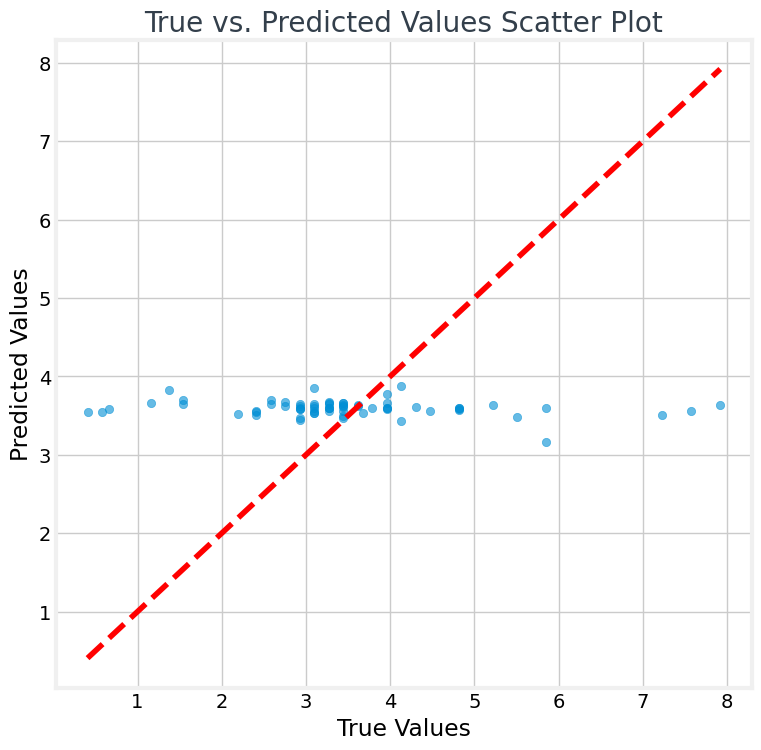

In [ ]:
x_tr_old = np.array(prep_X(x_train_old, 1))
x_t_old = np.array(prep_X(x_test_old, 1))
y_tr_old = np.array(y_train_old[1:])
y_t_old = np.array(y_test_old[1:])


rnns = Sequential()
rnns.add(Input(shape=(1,11)))
rnns.add(SimpleRNN(128,activation = 'relu'))
#rnns.add(Dense(128,activation = 'relu'))
rnns.add(Dense(1))

rnns.compile(loss='mean_absolute_error', optimizer='adam', run_eagerly=True)
#generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=t, batch_size=32)
# Fitting the rnn to the Training set
rnns.fit(x_tr_old, y_tr_old, batch_size = 32, shuffle = True, epochs=100, verbose = 2)
#test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=t, batch_size=32)
y_pred_old2 = rnns.predict(x_t_old)

mae = np.mean(mean_absolute_error(y_t_old,y_pred_old2))
rmse = math.sqrt(np.mean(mean_squared_error(y_t_old,y_pred_old2)))
r2 = np.mean(r2_score(list(y_t_old), y_pred_old2))
mape = np.mean(np.abs((list(y_t_old) - y_pred_old2) / list(y_t_old)) * 100)
print("---------------------------------")
print("RMSE = ",rmse_score)
print("MAE = ",mae_score)
print("R2 = ",r2)
print("MAPE = ",mape)

plt.figure(figsize=(8, 8))
plt.scatter(y_t_old, y_pred_old2, alpha=0.6)
plt.plot([min(y_t_old), max(y_t_old)], [min(y_t_old), max(y_t_old)], color='red', linestyle='--', label='Diagonal Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values Scatter Plot')
plt.savefig("rnnTvP2.png", dpi = 200)
plt.show()

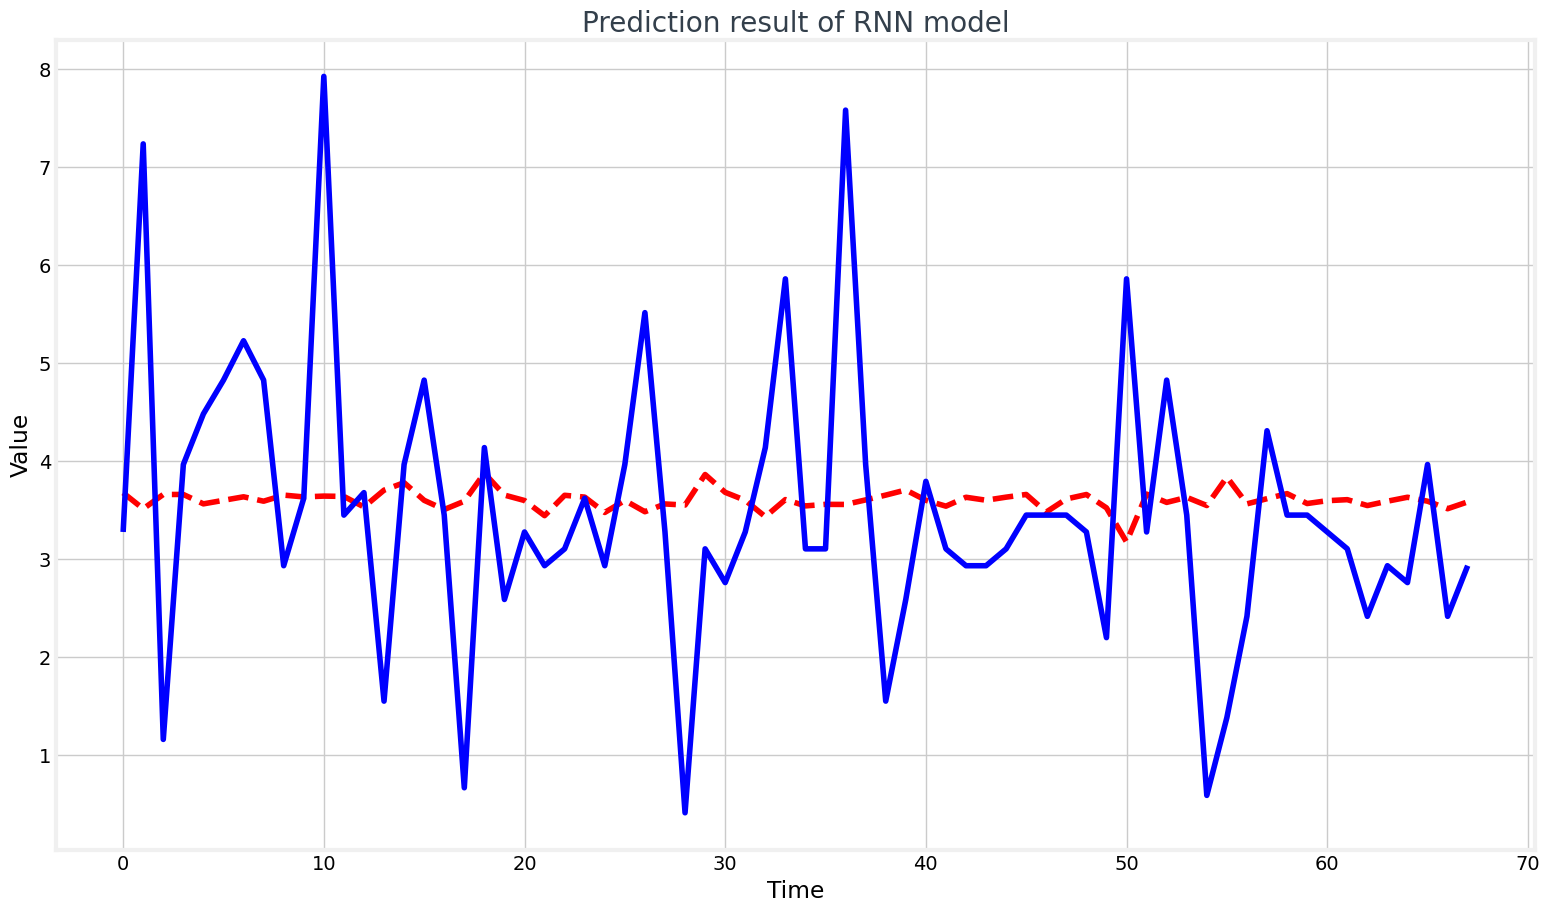

In [ ]:
plt.figure(figsize=(17,10))
y_t = list(y_t_old)
plt.plot(y_pred_old2, color='red', linestyle='--',label='Predicted')
plt.plot(y_t, color='blue', linestyle='-',label='Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prediction result of RNN model')
plt.savefig("rnn2.png", dpi=150)
plt.show()

LSTM

Epoch 1/100
5/5 - 2s - 469ms/step - loss: 3.4160
Epoch 2/100
5/5 - 0s - 9ms/step - loss: 3.3306
Epoch 3/100
5/5 - 0s - 12ms/step - loss: 3.2368
Epoch 4/100
5/5 - 0s - 11ms/step - loss: 3.1316
Epoch 5/100
5/5 - 0s - 12ms/step - loss: 3.0155
Epoch 6/100
5/5 - 0s - 10ms/step - loss: 2.8852
Epoch 7/100
5/5 - 0s - 9ms/step - loss: 2.7423
Epoch 8/100
5/5 - 0s - 12ms/step - loss: 2.5776
Epoch 9/100
5/5 - 0s - 12ms/step - loss: 2.3942
Epoch 10/100
5/5 - 0s - 10ms/step - loss: 2.1889
Epoch 11/100
5/5 - 0s - 12ms/step - loss: 1.9607
Epoch 12/100
5/5 - 0s - 10ms/step - loss: 1.7136
Epoch 13/100
5/5 - 0s - 9ms/step - loss: 1.4504
Epoch 14/100
5/5 - 0s - 13ms/step - loss: 1.2399
Epoch 15/100
5/5 - 0s - 13ms/step - loss: 1.1055
Epoch 16/100
5/5 - 0s - 13ms/step - loss: 1.1041
Epoch 17/100
5/5 - 0s - 10ms/step - loss: 1.1268
Epoch 18/100
5/5 - 0s - 9ms/step - loss: 1.1285
Epoch 19/100
5/5 - 0s - 13ms/step - loss: 1.1056
Epoch 20/100
5/5 - 0s - 15ms/step - loss: 1.0921
Epoch 21/100
5/5 - 0s - 25ms/ste

---------------------------------
RMSE =  0.7439648077352203
MAE =  0.4340463596055018
R2 =  -0.031124052878353403
MAPE =  52.24307385511733


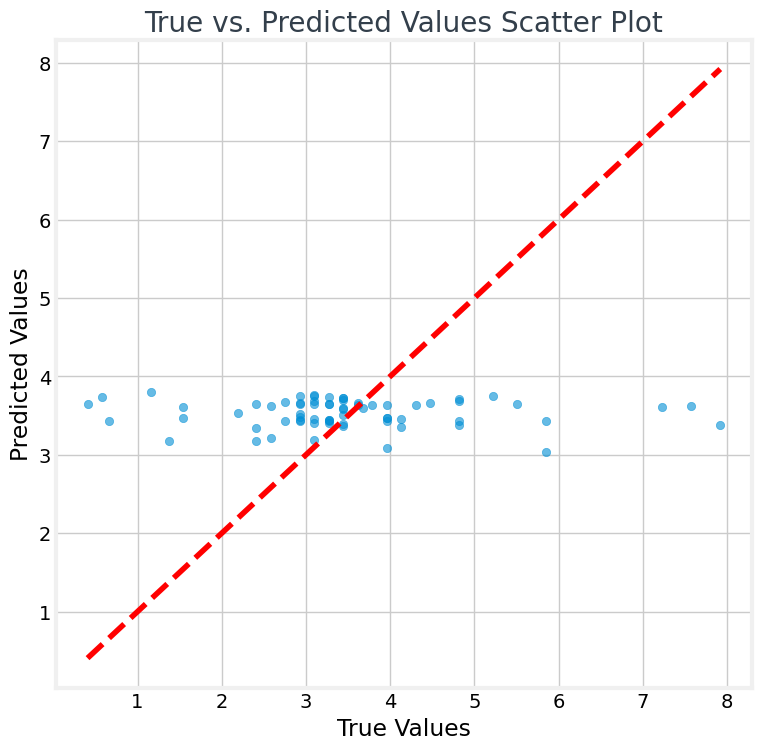

In [ ]:
lstm = Sequential()
lstm.add(Input(shape=(1,11)))
lstm.add(LSTM(128,activation = 'relu'))
#lstm.add(Dense(128,activation = 'relu'))
lstm.add(Dense(1))

lstm.compile(loss='mean_absolute_error', optimizer='adam')
#generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=t, batch_size=32)
# Fitting the rnn to the Training set
lstm.fit(x_tr_old, y_tr_old, batch_size = 32, shuffle = True, epochs=100, verbose = 2)
#test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=t, batch_size=32)
y_pred_old2 = lstm.predict(x_t_old)

mae = np.mean(mean_absolute_error(y_t_old,y_pred_old2))
rmse = math.sqrt(np.mean(mean_squared_error(y_t_old,y_pred_old2)))
r2 = np.mean(r2_score(list(y_t_old), y_pred_old2))
mape = np.mean(np.abs((list(y_t_old) - y_pred_old2) / list(y_t_old)) * 100)
print("---------------------------------")
print("RMSE = ",rmse_score)
print("MAE = ",mae_score)
print("R2 = ",r2)
print("MAPE = ",mape)

plt.figure(figsize=(8, 8))
plt.scatter(y_t_old, y_pred_old2, alpha=0.6)
plt.plot([min(y_t_old), max(y_t_old)], [min(y_t_old), max(y_t_old)], color='red', linestyle='--', label='Diagonal Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values Scatter Plot')
plt.savefig("lstmTvP2.png", dpi = 200)
plt.show()

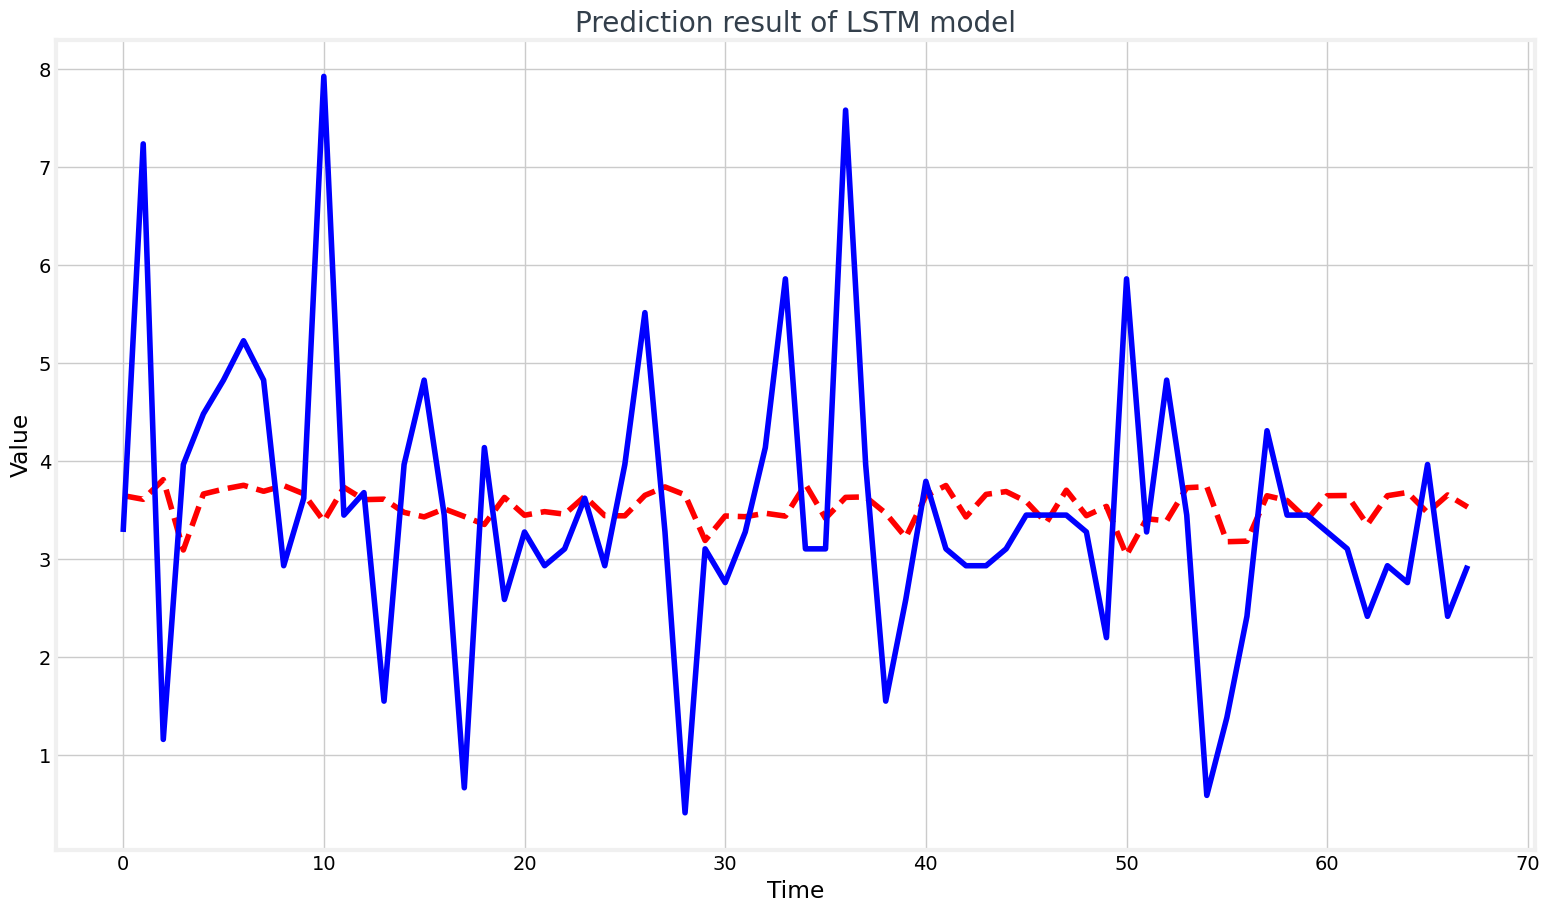

In [ ]:
plt.figure(figsize=(17,10))
y_t = list(y_t_old)
plt.plot(y_pred_old2, color='red', linestyle='--',label='Predicted')
plt.plot(y_t, color='blue', linestyle='-',label='Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prediction result of LSTM model')
plt.savefig("lstm2.png", dpi=150)
plt.show()

### HP Tuning Results

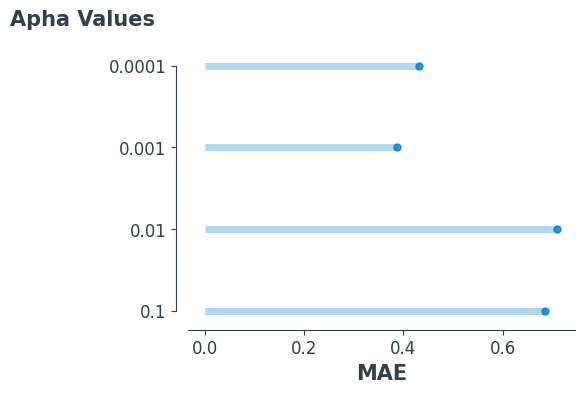

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

# create some fake data
MAEs = pd.Series([0.686076, 0.710549, 0.386860, 0.430781],
                        index=['0.1', '0.01', '0.001', '0.0001'])
df = pd.DataFrame({'MAE' : MAEs})

# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(df.index)+1))

fig, ax = plt.subplots(figsize=(5,3.5))

# create for each expense type an horizontal line that starts at x = 0 with the length
# represented by the specific expense MAE value.
plt.hlines(y=my_range, xmin=0, xmax=df['MAE'], color='#007ACC', alpha=0.3, linewidth=5)

# create for each expense type a dot at the level of the expense MAE value
plt.plot(df['MAE'], my_range, "o", markersize=5, color='#007ACC', alpha=0.8)

# set labels
ax.set_xlabel('MAE', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, df.index)

# add an horizonal label for the y axis
fig.text(-0.23, 0.96, 'Apha Values', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds((1,len(my_range)))
#ax.set_xlim(0,25)

ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

plt.savefig('alpha.png', dpi=300, bbox_inches='tight')

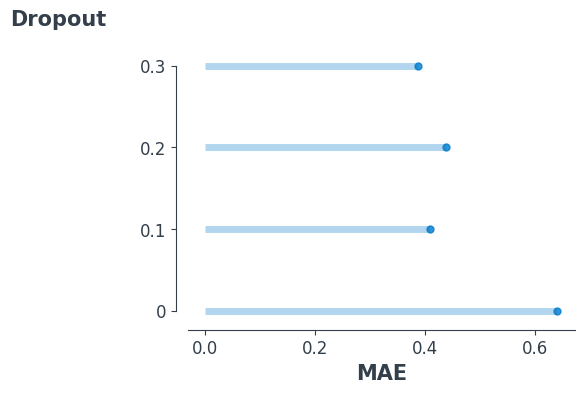

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

# create some fake data
MAEs = pd.Series([0.641267, 0.409330, 0.438896, 0.386860],
                        index=['0', '0.1', '0.2', '0.3'])
df = pd.DataFrame({'MAE' : MAEs})

# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(df.index)+1))

fig, ax = plt.subplots(figsize=(5,3.5))

# create for each expense type an horizontal line that starts at x = 0 with the length
# represented by the specific expense MAE value.
plt.hlines(y=my_range, xmin=0, xmax=df['MAE'], color='#007ACC', alpha=0.3, linewidth=5)

# create for each expense type a dot at the level of the expense MAE value
plt.plot(df['MAE'], my_range, "o", markersize=5, color='#007ACC', alpha=0.8)

# set labels
ax.set_xlabel('MAE', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, df.index)

# add an horizonal label for the y axis
fig.text(-0.23, 0.96, 'Dropout', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds((1,len(my_range)))
#ax.set_xlim(0,25)

ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

plt.savefig('drop.png', dpi=300, bbox_inches='tight')

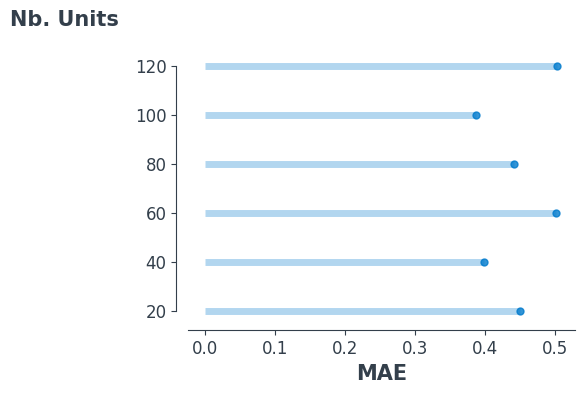

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

# create some fake data
MAEs = pd.Series([0.450033, 0.399201, 0.502061, 0.442441, 0.386860, 0.503926],
                        index=['20', '40', '60', '80', '100', '120'])
df = pd.DataFrame({'MAE' : MAEs})

# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(df.index)+1))

fig, ax = plt.subplots(figsize=(5,3.5))

# create for each expense type an horizontal line that starts at x = 0 with the length
# represented by the specific expense MAE value.
plt.hlines(y=my_range, xmin=0, xmax=df['MAE'], color='#007ACC', alpha=0.3, linewidth=5)

# create for each expense type a dot at the level of the expense MAE value
plt.plot(df['MAE'], my_range, "o", markersize=5, color='#007ACC', alpha=0.8)

# set labels
ax.set_xlabel('MAE', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, df.index)

# add an horizonal label for the y axis
fig.text(-0.23, 0.96, 'Nb. Units', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds((1,len(my_range)))
#ax.set_xlim(0,25)

ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

plt.savefig('units.png', dpi=300, bbox_inches='tight')

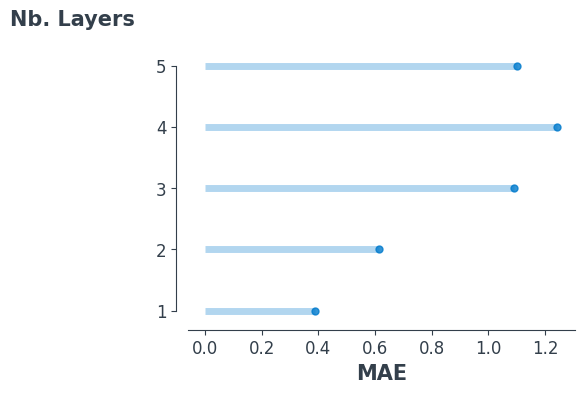

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

# create some fake data
MAEs = pd.Series([0.386860, 0.613093, 1.089807, 1.243954, 1.101312],
                        index=['1', '2', '3', '4', '5'])
df = pd.DataFrame({'MAE' : MAEs})

# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(df.index)+1))

fig, ax = plt.subplots(figsize=(5,3.5))

# create for each expense type an horizontal line that starts at x = 0 with the length
# represented by the specific expense MAE value.
plt.hlines(y=my_range, xmin=0, xmax=df['MAE'], color='#007ACC', alpha=0.3, linewidth=5)

# create for each expense type a dot at the level of the expense MAE value
plt.plot(df['MAE'], my_range, "o", markersize=5, color='#007ACC', alpha=0.8)

# set labels
ax.set_xlabel('MAE', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, df.index)

# add an horizonal label for the y axis
fig.text(-0.23, 0.96, 'Nb. Layers', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds((1,len(my_range)))
#ax.set_xlim(0,25)

ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

plt.savefig('layers.png', dpi=300, bbox_inches='tight')

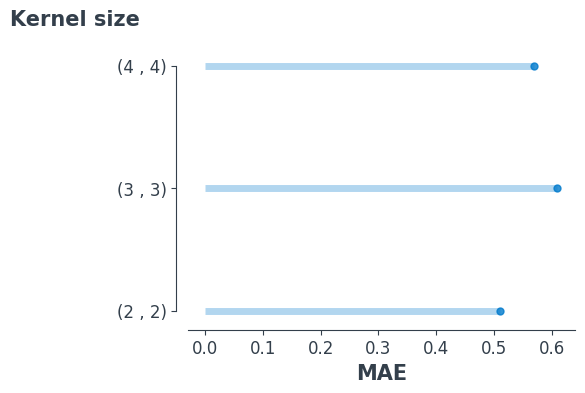

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

# create some fake data
MAEs = pd.Series([0.51, 0.61, 0.57],
                        index=['(2 , 2)', '(3 , 3)', '(4 , 4)'])
df = pd.DataFrame({'MAE' : MAEs})

# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(df.index)+1))

fig, ax = plt.subplots(figsize=(5,3.5))

# create for each expense type an horizontal line that starts at x = 0 with the length
# represented by the specific expense MAE value.
plt.hlines(y=my_range, xmin=0, xmax=df['MAE'], color='#007ACC', alpha=0.3, linewidth=5)

# create for each expense type a dot at the level of the expense MAE value
plt.plot(df['MAE'], my_range, "o", markersize=5, color='#007ACC', alpha=0.8)

# set labels
ax.set_xlabel('MAE', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, df.index)

# add an horizonal label for the y axis
fig.text(-0.23, 0.96, 'Kernel size', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds((1,len(my_range)))
#ax.set_xlim(0,25)

ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

plt.savefig('kernel.png', dpi=300, bbox_inches='tight')

## GAP Results

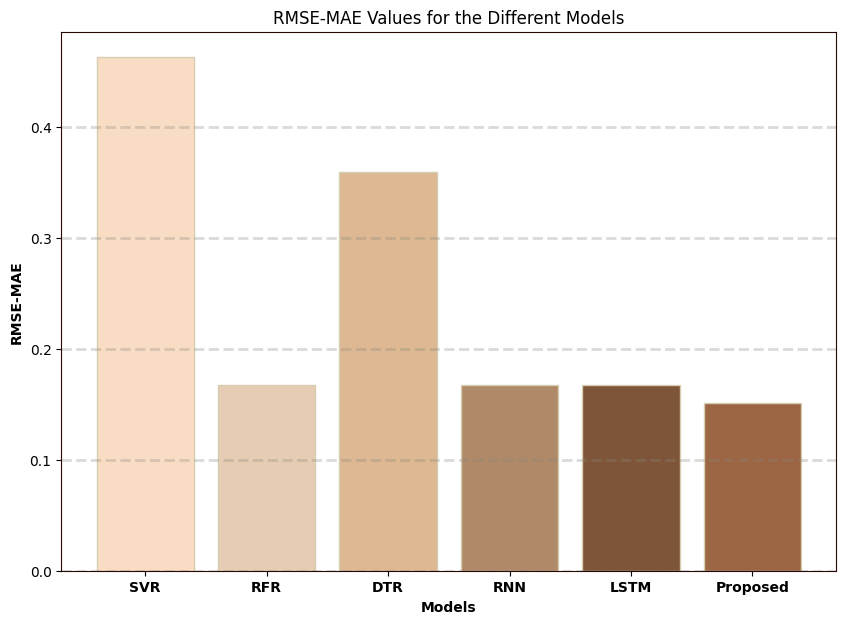

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#250902'


data = [['SVR', 0.463], ['RFR', 0.1672], ['DTR', 0.36],  ['RNN', 0.1672],  ['LSTM', 0.1672] , ['Proposed', 0.1516]]
df = pd.DataFrame(data, columns=['Models', 'RMSE-MAE values'])
c = ['#f9dcc4', '#e6ccb2', '#ddb892', '#b08968', '#7f5539', '#9c6644']

plt.figure(figsize=(10,7))
plt.xticks(range(6), df['Models'],weight = 'bold')
plt.xlabel('Models',fontweight='bold')
plt.ylabel('RMSE-MAE',fontweight='bold')
plt.title('RMSE-MAE Values for the Different Models')
plt.bar(range(6), df['RMSE-MAE values'], color=c, alpha=1, edgecolor = '#d7ceb2')
plt.grid(color='#87877f', linestyle='--', linewidth=2, axis='y', alpha=0.3)
plt.savefig("rmse-mae1",dpi= 250)
plt.show()